# CODEX analyses

## Imports and data loading

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib3x import Path
from time import time
import copy
from skimage import color
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import umap
# if not installed run: conda install -c conda-forge umap-learn
import hdbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import loguniform

from skimage import io

from scipy.stats import ttest_ind    # Welch's t-test
from scipy.stats import mannwhitneyu # Mann-Whitney rank test
from scipy.stats import ks_2samp     # Kolmogorov-Smirnov statistic

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

In [27]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [29]:
RUN_LONG = True

### Objects data

File that contains all the detected objects (the cells) across all samples.

In [30]:
data_dir = Path("../data/raw/CODEX_CTCL")
try:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.jbl"
    obj = joblib.load(objects_path)
except FileNotFoundError:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.xlsx"
    obj = pd.read_excel(objects_path, skiprows=2)
obj

Count  EventCount  Index in File  ClusterID FileName  ClusterName  \
0            0           1             60      33987   reg001      B cells   
1            1           1             94      33987   reg001      B cells   
2            2           1            198      33987   reg001      B cells   
3            3           1            284      33987   reg001      B cells   
4            4           1            298      33987   reg001      B cells   
...        ...         ...            ...        ...      ...          ...   
117165  116917           1            633      33981   reg066  vasculature   
117166  116918           1            677      33981   reg066  vasculature   
117167  116919           1            681      33981   reg066  vasculature   
117168  116920           1            705      33981   reg066  vasculature   
117169  116921           1            711      33981   reg066  vasculature   

        Spots  Patients  Groups      FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
0           1         1       1   0.692403  ...          0           0   
1           1         1       1   8.094747  ...          0           0   
2           1         1       1   4.110389  ...          0           0   
3           1         1       1   0.000000  ...          0           0   
4           1         1       1   2.937673  ...          0           0   
...       ...       ...     ...        ...  ...        ...         ...   
117165     66        14       4  84.269714  ...          0           0   
117166     66        14       4  56.425945  ...          0           0   
117167     66        14       4  63.152092  ...          0           0   
117168     66        14       4  66.873306  ...          0           0   
117169     66        14       4  17.966373  ...          0           0   

        PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
0                0           0          0            0           0          0   
1                0           0          0            0           0          0   
2                0           0          0            0           0          0   
3                0           0          0            0           0          0   
4                0           0          0            0           0          0   
...            ...         ...        ...          ...         ...        ...   
117165           0           0          0            0           0          0   
117166           0           0          0            0           0          0   
117167           0           0          0            0           0          0   
117168           0           0          0            0           0          0   
117169           0           0          0            0           0          0   

        Ki67+tumor  original_index  
0                0               0  
1                0               1  
2                0               2  
3                0               3  
4                0               4  
...            ...             ...  
117165           0          116917  
117166           0          116918  
117167           0          116919  
117168           0          116920  
117169           0          116921  

[117170 rows x 121 columns]

In [31]:
# sample_cols = obj.columns[:10]
obj.rename(columns={'X': 'x', 'Y': 'y', 'Z':'z'}, inplace=True)
sample_cols = ['FileName', 'ClusterName', 'Patients', 'Spots' ,'Groups']
marker_cols = obj.columns[9:67]
marker_cols = [x for x in marker_cols if x != 'HOECHST1:Cyc_1_ch_1']
# cell_pos_cols = obj.columns[69:76]
cell_pos_cols = ['x', 'y'] # no z this time ! 
# cell_type_cols = obj.columns[76:101]
cell_type_cols = list(obj.columns[75:96])
marker_posit_cols = list(obj.columns[100:-1])
all_cols = sample_cols + marker_cols + cell_pos_cols + cell_type_cols + marker_posit_cols
nb_clusters = obj['ClusterName'].unique().size

In [32]:
obj.shape

(117170, 121)

In [33]:
obj[['FileName', 'Patients', 'Count']].groupby(['Patients', 'FileName']).count()

Count
Patients FileName       
1        reg001     1301
         reg002     2324
         reg003     1145
         reg004      745
2        reg005      112
...                  ...
14       reg062     3696
         reg063     3610
         reg064     4163
         reg065     1238
         reg066      792

[69 rows x 1 columns]

### Response status pre/post treatment

In [34]:
code_groups = {
  1: 'Responder, pre-treatment',
  2: 'Non-responder, pre-treatment',
  3: 'Responder, post-treatment',
  4: 'Non-responder, post-treatment',
} 

In [35]:
status_path = data_dir / "41467_2021_26974_MOESM5_ESM - Patients_spots_conditons.xlsx"
status = pd.read_excel(status_path, skiprows=2, usecols=['Patients', 'Groups', 'Spots'])
# samples 25, 36, 37, 40, 44 are missing
# 36 and 37 should be patient 9
# 40 is either 10 or 11
# 44 is 11, which make 4 samples of this patient
# so probably 40 is patient 10

# /!\ this is a guess that makes sense, but it still might be wrong /!\
guessed_data = [[9, 1, 36],
                [9, 3, 37],
                [10, 3, 40],
                [11, 3, 44]]
status = pd.concat([status, pd.DataFrame(guessed_data, columns=status.columns)], axis=0)

status['FileName'] = status['Spots'].apply(lambda x: f'reg{x:03}')
# pd.set_option('display.max_rows', 100)

if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[68 rows x 3 columns]

### Survival data

In [36]:
survival_path = data_dir / "cohort_response.ods"
surv = pd.read_excel(survival_path)
surv.index = surv['Patient ID']
surv.drop(columns=['Patient ID'], inplace=True)
# surv.index.name = 'sample'
surv

Age at screening (years)  Gender Diagnosis Disease Stage  \
Patient ID                                                             
1                              76.14    Male        MF          IIIA   
2                              60.59    Male        MF          IIIB   
3                              52.01    Male        SS           IVA   
4                              85.14  Female        SS           IVA   
5                              75.24    Male        MF           IIB   
6                              46.74    Male        MF           IVA   
7                              46.71  Female        MF          IIIB   
8                              67.44    Male        SS          IIIB   
9                              77.65  Female        SS           IVA   
10                             66.40    Male        MF          IIIA   
11                             72.23    Male        SS           IVA   
12                             72.59    Male        SS           IVA   
13                             44.10  Female        SS           IVA   
14                             63.69    Male        MF            IB   

            Prior therapies Response status        Biopsy timepoints  \
Patient ID                                                             
1                         3       Responder                 Pre, EOT   
2                         4       Responder                 Pre, EOT   
3                         3   Non-responder                 Pre, EOT   
4                         4   Non-responder                 Pre, EOT   
5                         6       Responder                 Pre, EOT   
6                         9   Non-responder            Pre, CO2, EOT   
7                         3   Non-responder                 Pre, EOT   
8                         1   Non-responder                 Pre, EOT   
9                         6       Responder            Pre, CO2, EOT   
10                        2       Responder                      Pre   
11                        3       Responder            Pre, Response   
12                        5   Non-responder         Pre, Progression   
13                        1       Responder  Pre, CO2, Response, EOT   
14                        5   Non-responder  Pre, CO2, Response, EOT   

            CO2 (weeks)  Response / progression time (weeks)  \
Patient ID                                                     
1                   NaN                                  NaN   
2                   NaN                                  NaN   
3                   NaN                                  NaN   
4                   NaN                                  NaN   
5                   NaN                                  NaN   
6                   3.0                                  NaN   
7                   NaN                                  NaN   
8                   NaN                                  NaN   
9                   3.0                                  NaN   
10                  NaN                                  NaN   
11                  NaN                                 22.0   
12                  NaN                                 15.0   
13                  3.0                                 15.0   
14                  3.0                                 10.0   

            EOT time (weeks)  Death time (weeks)  Follow-up time (weeks)  
Patient ID                                                                
1                      104.0                 NaN                     142  
2                      104.0                 NaN                     151  
3                       98.0                98.0                      98  
4                      104.0               142.0                     142  
5                      104.0                 NaN                     103  
6                       25.0                 NaN                      25  
7                        9.0                 NaN                       9  
8     

## Spatial networks reconstruction

### Load samples of one patient

We will have a look at the spatial networks of the 4 samples of the first patient to check they seem "correct", i.e. not over nor under connected.

processing filename reg001
processing filename reg002
processing filename reg003
processing filename reg004


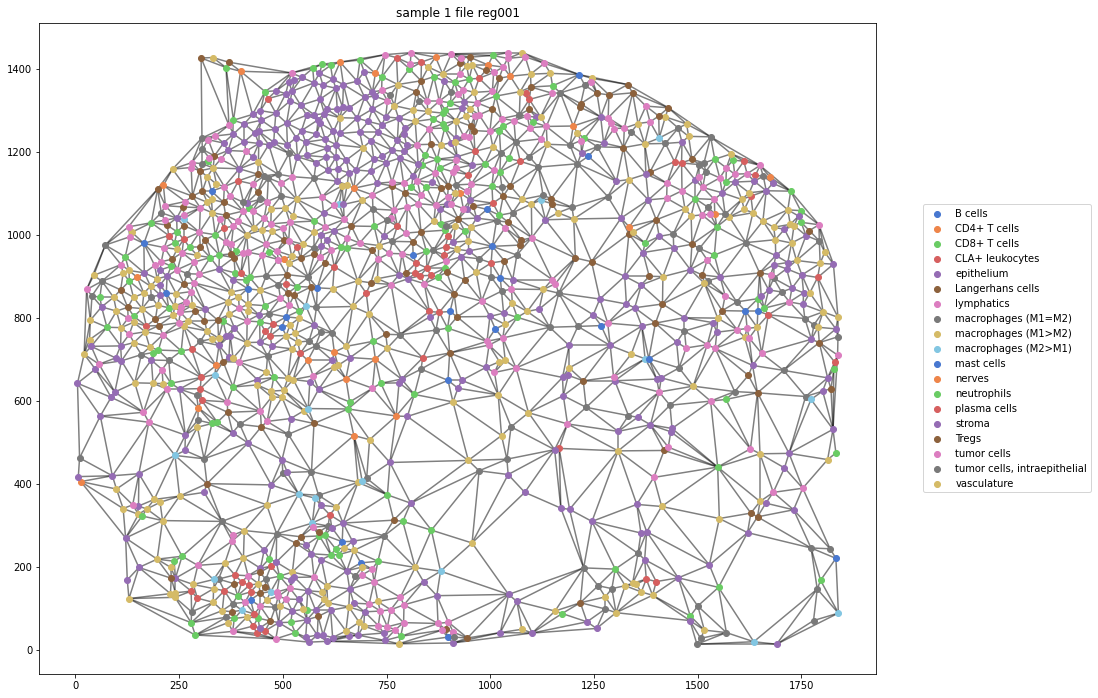

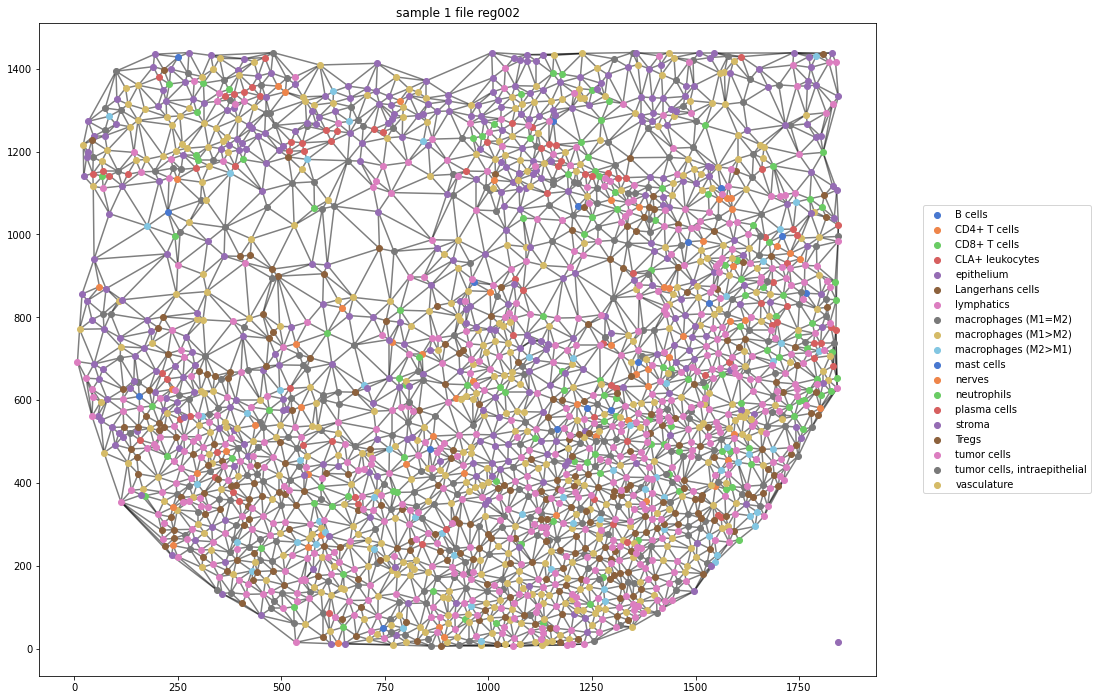

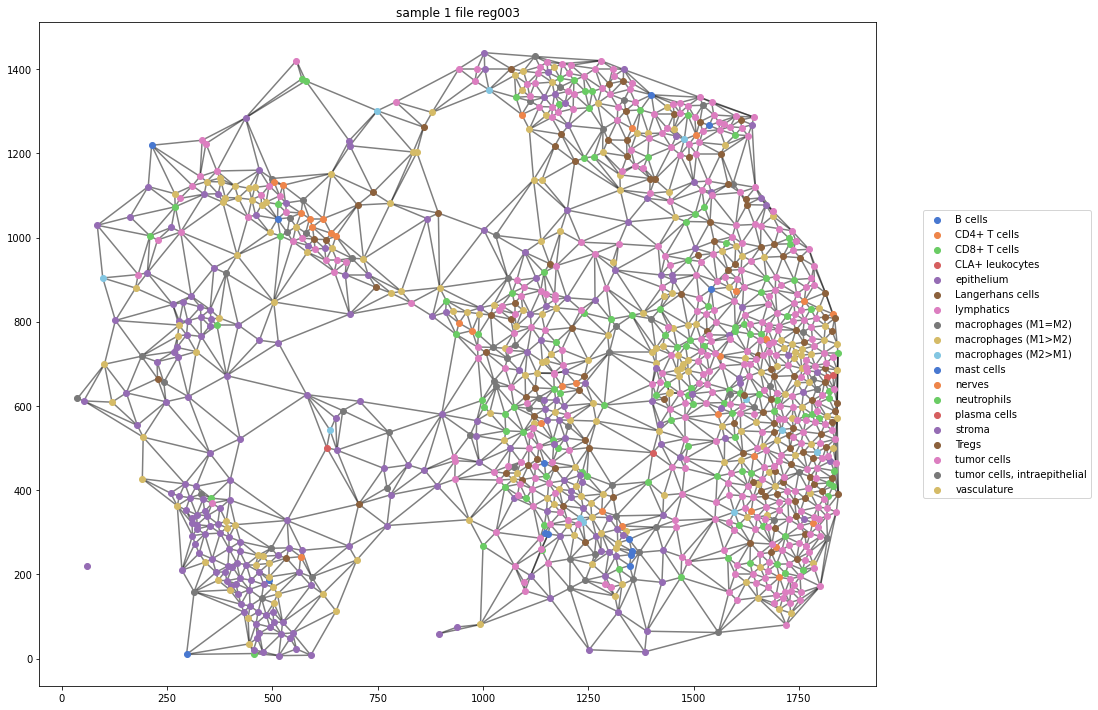

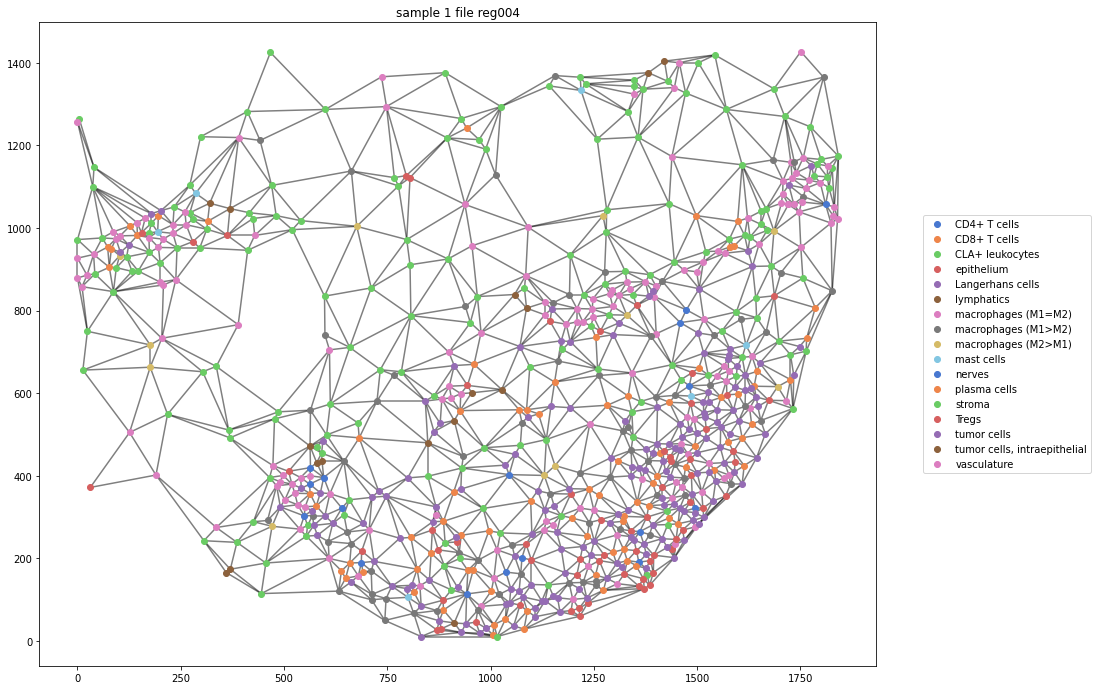

In [11]:
sample_id = 1  # that's our patient
select_sample = obj['Patients'] == sample_id
filenames = obj.loc[select_sample, 'FileName'].unique()  # look for the several samples per patient
for filename in filenames:
    print("processing filename {}".format(filename))
    select_file = obj['FileName'] == filename
    nodes = obj.loc[select_sample & select_file, all_cols]
    coords = nodes[cell_pos_cols].values
    pairs = ty.build_delaunay(coords, trim_dist=200)
    # we want to avoid isolated cells, so we link them to their 2 closest neighbors
    # pairs = ty.link_solitaries(coords, pairs, method='knn', k=2)

    fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                              legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
    plt.title("sample {} file {}".format(sample_id, filename))

### All samples network reconstruction

#### Plot spatial networks

In [37]:
processed_dir = Path('../data/processed/CODEX_CTCL')
save_dir = processed_dir / "all_samples_networks_xy_solitary-0"

In [13]:
# Choose optimal distances

files_dst = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

k_sol = 0 

if RUN_LONG:
    for filename in files_dst:
        print("    processing filename {}".format(filename))
        select_file = obj['FileName'] == filename
        nodes = obj.loc[select_file, all_cols]
        coords = nodes[cell_pos_cols].values
        pairs = ty.build_delaunay(coords, trim_dist=200)
        print("    ", end="")
        if k_sol > 0:
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)
        distances = ty.distance_neighbors(coords, pairs)

        fig, ax = ty.plot_network_distances(
            coords, pairs, distances, labels=nodes['ClusterName'],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)}
            )
        plt.axis('off');
        title = f"network_distances_filename-{filename}"
        plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
        plt.show()

In [38]:
trim_dist = 'percentile_size' # or 200
k_sol = 0 # or 1, 2, 3, ...
save_dir = processed_dir / f"all_samples_networks_xy_trim_dist-{trim_dist}_solitary-{k_sol}"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=200)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                                      legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"sample-{sample_id}_filename-{filename}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [15]:
if RUN_LONG:
    edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
    # number of nodes previously seen
    nb_nodes = 0
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            # increase ids in pairs by the number of nodes in all previously loaded networks
            pairs = pairs + nb_nodes
            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            # update number of nodes for next network
            nb_nodes = nb_nodes + coords.shape[0]
            edges_all = pd.concat([edges_all, edges], ignore_index=True)
    edges_all.to_csv(save_dir / 'sample_all-edges.csv', index=False)
else:
    edges_all = pd.read_csv(save_dir / 'sample_all-edges.csv')

In [16]:
# or save in separate file for convenience
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_csv(save_dir / f'edges_sample-{filename}.csv', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, potentially predictive of response to therapy.

### Cell types proportions

In [17]:
# we add attributes to nodes to color network figures
nodes_all = obj[cell_pos_cols].copy()
nodes_all['CellCluster'] = obj['ClusterName'].values
nodes_all = nodes_all.join(pd.get_dummies(obj['ClusterName']))
attribute_uniq = nodes_all['CellCluster'].unique()

In [18]:
# here we don't use `FileName` in the group / unstack procedure to aggregate statistics 
# per patient and condition (before / after treatment) rather than per sample.

count_types = obj[['Patients', 'Groups', 'Count']].join(nodes_all['CellCluster']).groupby(['Patients', 'Groups', 'CellCluster']).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient_per_condition.csv')
count_types.head(6)

CellCluster      B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                         
1        1            34            50           229               20   
         3             3            23           191                7   
2        1             6             3             5                3   
         3            79            29            18                0   
3        2             2           208           186               14   
         4             0            63           192                8   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells  Tregs  \
Patients Groups                                                             
1        1                 0                   0                42    350   
         3                 0                   0                15    160   
2        1                 0                   0                12     15   
         3                 0                   0                13     76   
3        2                 0                   2               130     99   
         4                 0                   8                63    157   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1              112          23  ...                  545   
         3               72          30  ...                  201   
2        1                6           5  ...                   71   
         3              259           0  ...                  265   
3        2             1759          24  ...                  397   
         4             2299           0  ...                  295   

CellCluster      macrophages (M2>M1)  mast cells  nerves  neutrophils  \
Patients Groups                                                         
1        1                        83           9      33           36   
         3                        22          17      24            2   
2        1                        64           3       6            1   
         3                       146          11      12            0   
3        2                        39          33      17            0   
         4                        43           8       6            0   

CellCluster      plasma cells  stroma  tumor cells  \
Patients Groups                                      
1        1                133     582          777   
         3                  4     317          527   
2        1                  4     203          155   
         3                 12     396         2900   
3        2                  4     328          546   
         4                  1     278          428   

CellCluster      tumor cells, intraepithelial  vasculature  
Patients Groups                                             
1        1                                 48          149  
         3                                  3          143  
2        1                                  2           95  
         3                                  0          166  
3        2                                274           86  
         4                                320          111  

[6 rows x 21 columns]

Instead of counts we use proportions of cell types per patient and condition.

In [19]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

CellCluster       B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2   

#### Descriptive statistics

In [15]:
pvals = mosna.find_DE_markers(prop_types, group_ref=1, group_tgt=2, group_var='Groups', composed_vars=False)
pvals = pvals.sort_values(by='pval', ascending=True)
pvals

pval  pval_corr
CellCluster                                      
macrophages (M1=M2)           0.212121   0.999961
CD4+ T cells                  0.212121   0.999961
tumor cells                   0.575175   0.999961
macrophages (M2>M1)           0.575175   0.999961
lymphatics                    0.575175   0.999961
Langerhans cells              0.575175   0.999961
B cells                       0.575175   0.999961
CD8+ T cells                  0.575175   0.999961
IDO+ stromal cells            0.575175   0.999961
vasculature                   0.575175   0.999961
Tregs                         0.962704   0.999961
epithelium                    0.962704   0.999961
tumor cells, intraepithelial  0.962704   0.999961
macrophages (M1>M2)           0.962704   0.999961
CLA+ leukocytes               0.962704   0.999961
nerves                        0.962704   0.999961
neutrophils                   0.962704   0.999961
stroma                        0.962704   0.999961
DCs, CD11c+                   0.999961   0.999961
mast cells                    0.999961   0.999961
plasma cells                  0.999961   0.999961

Cell types proportions are not significantly associated with response / non response in samples before treatment.  
But `mosna` can find composed variables potentially related to response of patients:

In [16]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=2)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [17]:
pvals.head(20)

pval  pval_corr
((lymphatics / macrophages (M1=M2)) / (macropha...  0.000583        1.0
((CD8+ T cells / nerves) / (Tregs / tumor cells))   0.008159        1.0
((lymphatics / macrophages (M1>M2)) / (stroma /...  0.008159        1.0
((lymphatics / tumor cells) / (macrophages (M1=...  0.008159        1.0
(lymphatics / macrophages (M1=M2))                  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / stroma) / (stroma / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((macrophages (M1=M2) / macrophages (M1>M2)) / ...  0.008159        1.0
((B cells / macrophages (M2>M1)) / (nerves / tu...  0.008159        1.0
((lymphatics / stroma) / (nerves / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (mast cel...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M2>M1) /...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1>M2) /...  0.008159        1.0
((CD4+ T cells / stroma) / (Tregs / lymphatics))    0.008159        1.0
((epithelium / nerves) / (epithelium / tumor ce...  0.008159        1.0
((macrophages (M1>M2) / vasculature) / (macroph...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1=M2) /...  0.008159        1.0
((CD4+ T cells / nerves) / (mast cells / tumor ...  0.008159        1.0

The first variables related to cell types proportions are composed variables of the 2nd order (ratio of ratios), only `lymphatics / macrophages (M1=M2)` appear in the simpler composed variables, but all corrected pvalues are > 0.05. This is because mosna produced *a lot* of composed variables.

#### Visualization

In [22]:
prop_types_comp

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

                 DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2          0.000000   

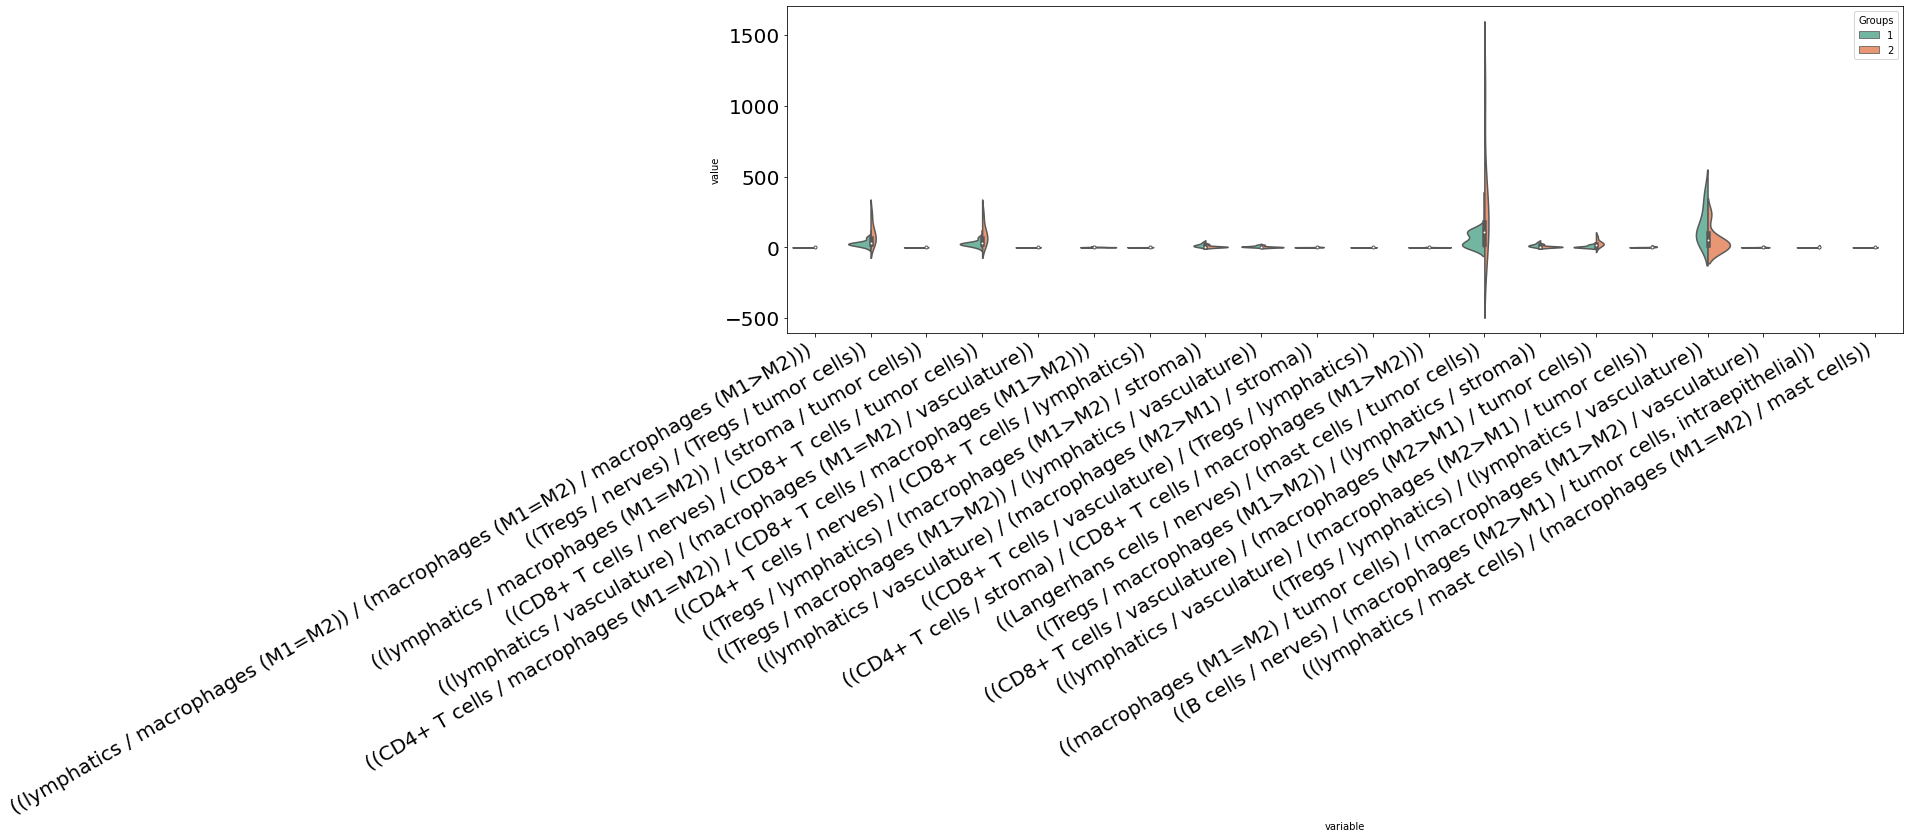

In [23]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

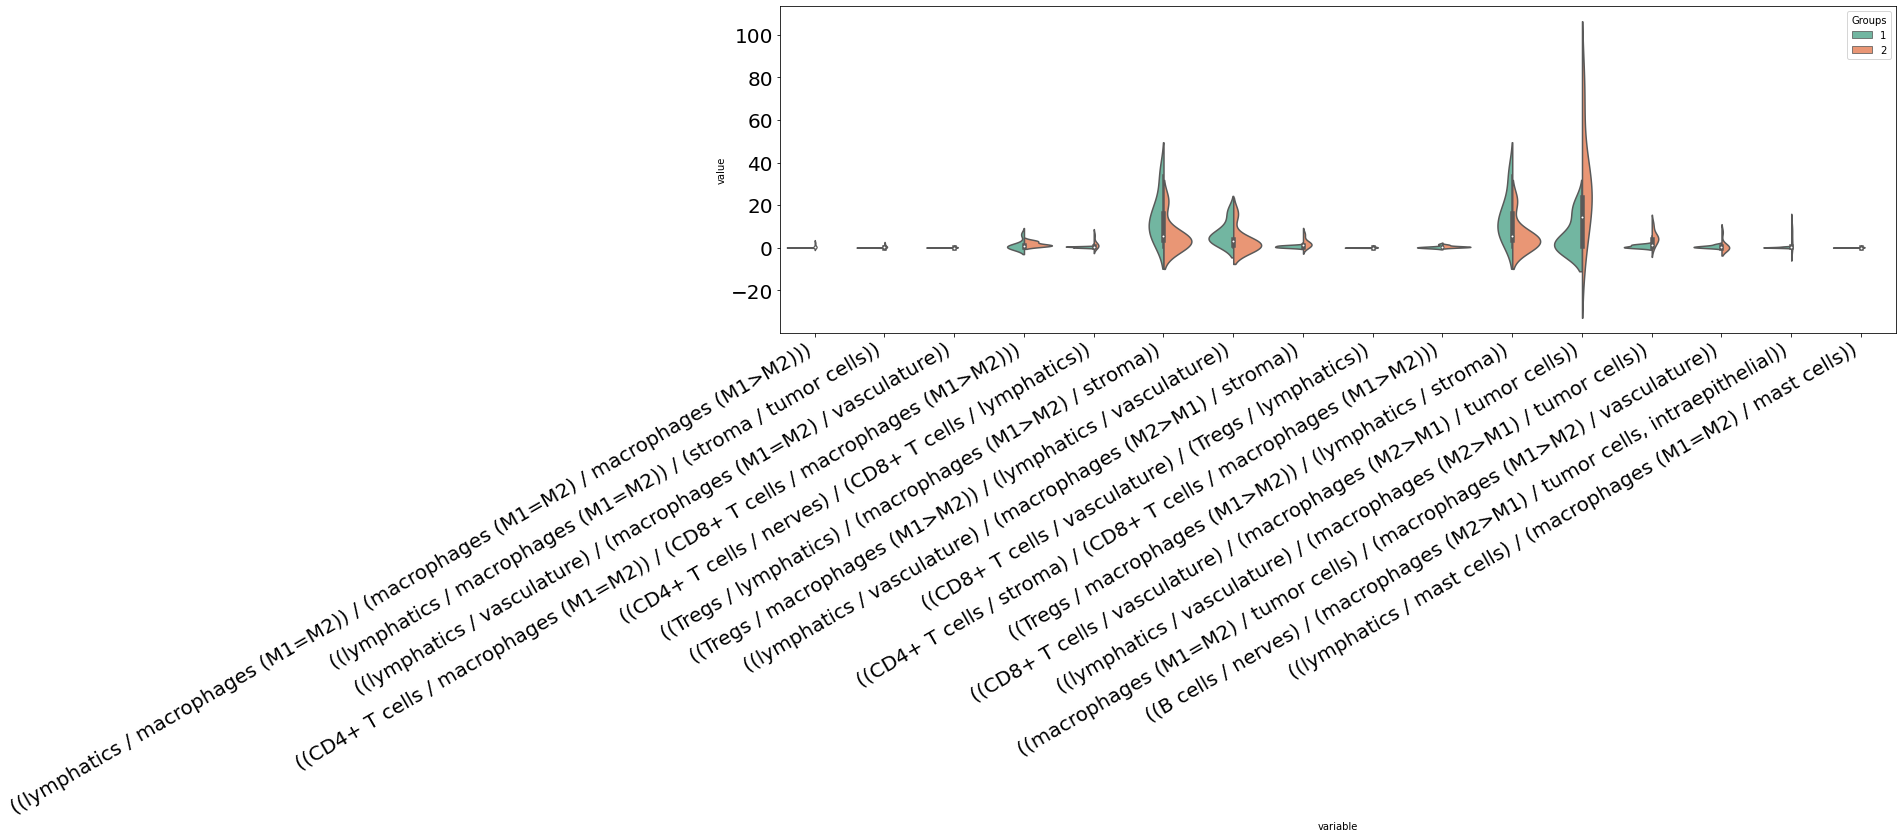

In [24]:
exclude_vars = [
    '((Langerhans cells / nerves) / (mast cells / tumor cells))',
    '((Tregs / lymphatics) / (lymphatics / vasculature))',
    '((Tregs / nerves) / (Tregs / tumor cells))',
    '((CD8+ T cells / nerves) / (CD8+ T cells / tumor cells))',
]
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    exclude_vars=exclude_vars,
    )

### Heatmap of cell types proportions

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


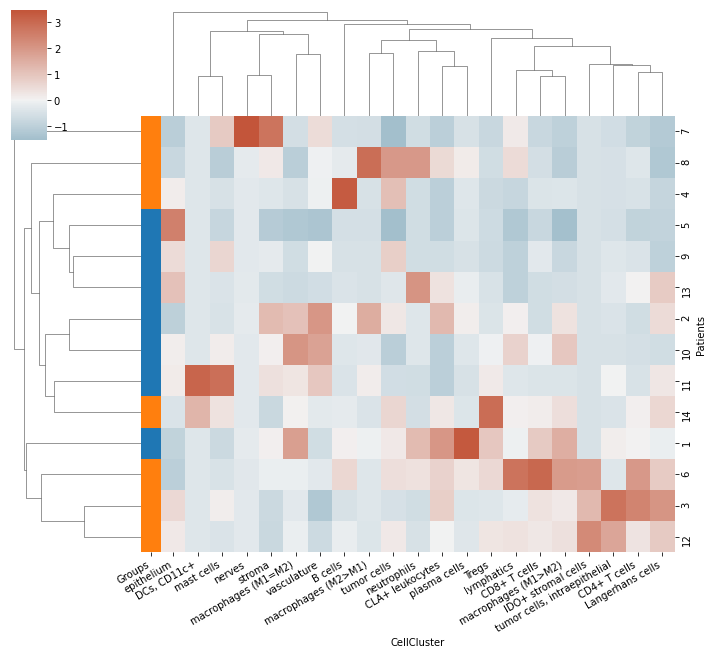

In [25]:
g = mosna.plot_heatmap(prop_types.reset_index(), obs_labels='Patients', group_var='Groups', groups=[1, 2])

There is no clear separation of patients into their respective groups from their proportions of cell types scaled across patients.

In [59]:
# we need to clean-up data for further analyses and visualizations
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 131834 non finite values
Imputing data


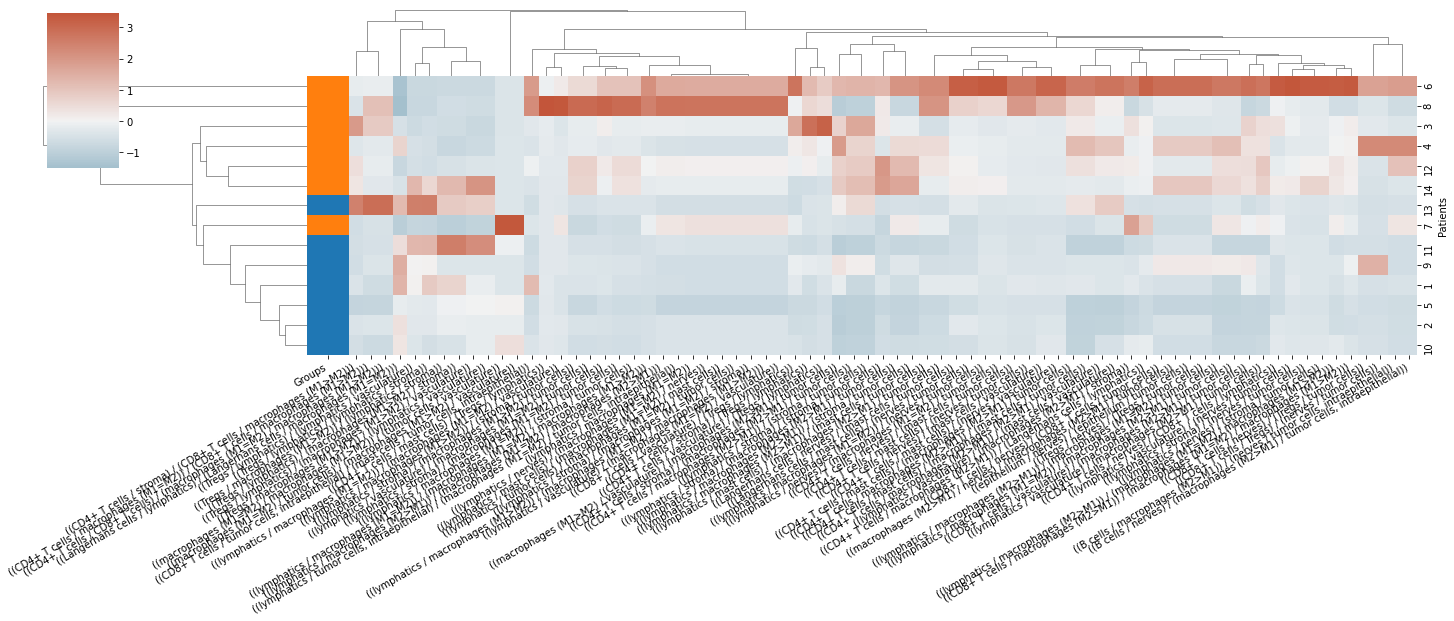

In [60]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index
# or to select only 20 variables:
# best_pval_names = pvals.head(20).index
mosna.plot_heatmap(
    prop_types_comp_cleaned[best_pval_names].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

By selecting the variables with p-values under 5%, although their corresponding corrected p-values are not significant, we can notice a much better separation between patients groups.

#### Stepwise logistic regression

In [28]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
model, included = mosna.stepwise_regression(X=prop_types_comp_cleaned, y_name='Groups', y_values=[1, 2], col_names=best_pval_names, verbose=True)

Add  ((Langerhans cells / lymphatics) / (Langerhans cells / macrophages (M1=M2))) with p-value 0.00186317
Add  ((macrophages (M1>M2) / vasculature) / (macrophages (M2>M1) / tumor cells)) with p-value 0.000234876
Add  ((CD8+ T cells / macrophages (M2>M1)) / (macrophages (M1=M2) / macrophages (M1>M2))) with p-value 0.00216709


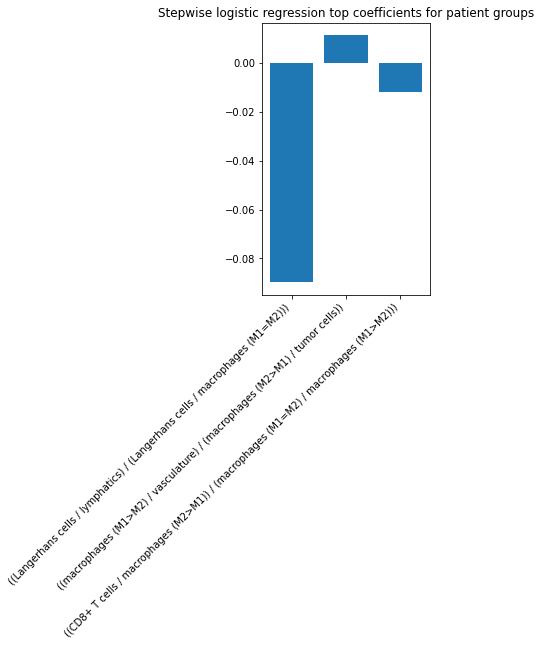

In [29]:
# plot the model's coefficients
coefs = model.params[1:] # skip intercept
nb_coefs = min(coefs.size, 20)
if nb_coefs > 0:
    fig, ax = plt.subplots(figsize=(nb_coefs,5))
    ax.bar(coefs.index, coefs)
    plt.xticks(rotation=45, ha='right');
    title = f"Stepwise logistic regression top coefficients for patient groups"
    plt.title(title)

#### Risk ratios

#### Survival analysis

### Marker-positive cells proportions

In [30]:
def highlight_under(s, thresh=0.05, color='darkorange'):
    '''
    highlight values that are under a threshold
    '''
    is_under = s <= thresh
    attr = 'background-color: {}'.format(color)
    return [attr if v else '' for v in is_under]

We have seen that cell types proportions don't explain response of patient to therapy. But maybe interactions between cell types play a role in response?  
To answer this question we will look at the *mixing matrix* and *assortativity* of tissue networks.  

## Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

###  Assortativity and Mixing Matrix

#### Computation of assortativity

In [37]:
processed_dir

PosixPath('../data/processed/CODEX_CTCL')

In [38]:
grouping = 'FileName'
n_shuffle = 20
load_dir = processed_dir / "all_samples_networks_xy_trim_dist-200_solitary-0"
save_dir = load_dir / "assortativity"
filename = f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'

if RUN_LONG:
    start = time()
    net_stats = mosna.batch_assort_mixmat(nodes_all, edges_all, 
                                    attributes=attribute_uniq, 
                                    groups=obj[grouping], 
                                    n_shuffle=n_shuffle,
                                    parallel_groups=False,
                                    memory_limit='100GB',
                                    save_intermediate_results=False, 
                                    dir_save_interm=save_dir)
    end = time()
    duration = end - start
    print(f"Assortativity took {duration}s for n_suffle {n_shuffle}")

    net_stats.index = net_stats['id']
    net_stats.drop(columns=['id'], inplace=True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net_stats.to_csv(save_dir / filename)
else:
    net_stats = pd.read_csv(save_dir / filename, index_col=0)

In [39]:
net_stats

# total  % B cells  % CD4+ T cells  % CD8+ T cells  % CLA+ leukocytes  \
id                                                                              
reg001     1301   0.017679        0.012298        0.082244           0.009224   
reg002     2324   0.004733        0.014630        0.052496           0.003442   
reg006      603   0.009950        0.004975        0.008292           0.004975   
reg035     2053   0.000487        0.007306        0.014613           0.000974   
reg036      618   0.001618        0.006472        0.033981           0.000000   
...         ...        ...             ...             ...                ...   
reg005      112   0.000000        0.000000        0.000000           0.000000   
reg018      458   0.000000        0.000000        0.000000           0.000000   
reg027      249   0.000000        0.004016        0.000000           0.000000   
reg026      257   0.000000        0.000000        0.000000           0.000000   
reg025      144   0.000000        0.000000        0.000000           0.000000   

        % DCs, CD11c+  % epithelium  % IDO+ stromal cells  % Langerhans cells  \
id                                                                              
reg001            0.0      0.069178                   0.0            0.016910   
reg002            0.0      0.009466                   0.0            0.008606   
reg006            0.0      0.006633                   0.0            0.019900   
reg035            0.0      0.500731                   0.0            0.004384   
reg036            0.0      0.021036                   0.0            0.003236   
...               ...           ...                   ...                 ...   
reg005            0.0      0.017857                   0.0            0.000000   
reg018            0.0      0.884279                   0.0            0.004367   
reg027            0.0      0.088353                   0.0            0.000000   
reg026            0.0      0.000000                   0.0            0.003891   
reg025            0.0      0.000000                   0.0            0.000000   

        % lymphatics  ...  vasculature - macrophages (M2>M1) Z  \
id                    ...                                        
reg001      0.011530  ...                            -1.271380   
reg002      0.003442  ...                            -2.001541   
reg006      0.008292  ...                            -2.001655   
reg035      0.000000  ...                            -0.896258   
reg036      0.006472  ...                            -1.825742   
...              ...  ...                                  ...   
reg005      0.000000  ...                            -1.401770   
reg018      0.000000  ...                                  NaN   
reg027      0.056225  ...                            -0.420084   
reg026      0.011673  ...                                  NaN   
reg025      0.000000  ...                                  NaN   

        vasculature - mast cells Z  vasculature - nerves Z  \
id                                                           
reg001                   -0.500000               -0.904534   
reg002                   -0.392232               -1.664479   
reg006                   -0.314485               -0.420084   
reg035                   -2.136829               -0.466252   
reg036                   -1.860521               -1.583385   
...                            ...                     ...   
reg005                   -0.333333                     NaN   
reg018                   -0.229416               -0.420084   
reg027                   -0.882596               -0.830747   
reg026                   -1.118034               -4.523879   
reg025                         NaN               -1.382047   

        vasculature - neutrophils Z  vasculature - plasma cells Z  \
id                                                                  
reg001                    -1.680336                     -1.485297   
reg002                    -

#### Example of Mixing Matrix

In [40]:
sample_id = 'reg001'
# TODO: reimplement the 'RAW' flag
# raw_cols = [x for x in net_stats.columns if x.endswith('RAW') and not x.startswith('assort')]
raw_cols = net_stats.iloc[:, 26:257].columns
z_cols = [x for x in net_stats.columns if x.endswith('Z') and not x.startswith('assort')]

mixmat_raw = mosna.series_to_mixmat(net_stats.loc[sample_id, raw_cols], discard=' RAW').astype(float)
mixmat_z = mosna.series_to_mixmat(net_stats.loc[sample_id, z_cols], discard=' Z').astype(float)
assort_raw = net_stats.loc[sample_id, "assort"]
assort_z = net_stats.loc[sample_id, "assort Z"]

# select_cols = np.logical_and(mixmat_raw.isna(axis=0) == 0, mixmat_z.isna(axis=0) == 0)

Raw assortativity by cell types: 1.00
Z-scored assortativity by cell types: 86.48


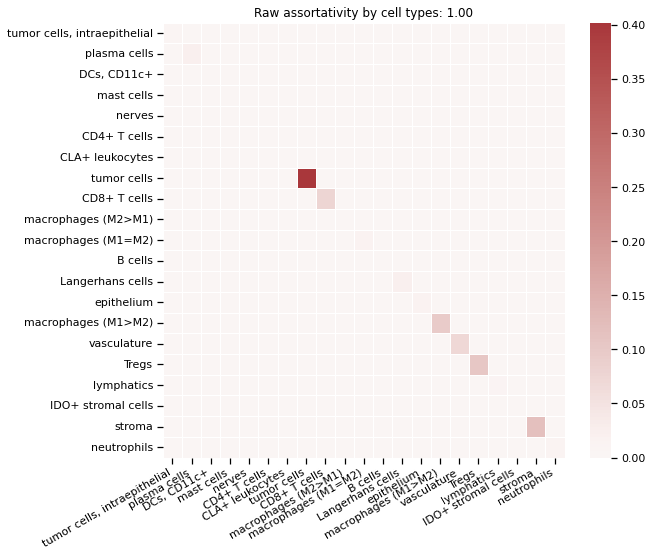

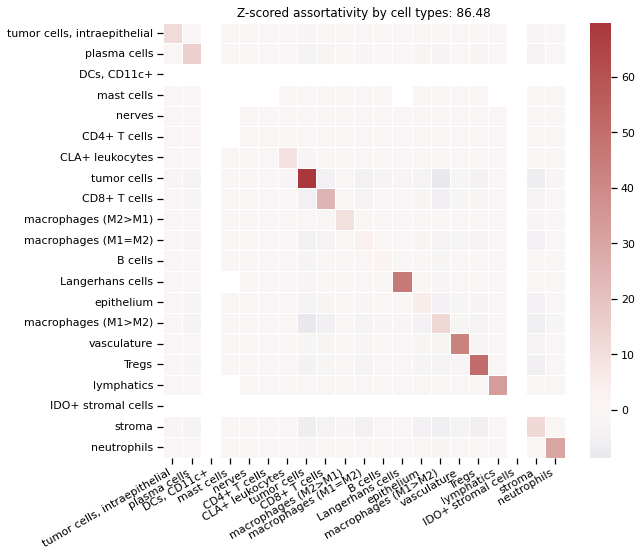

In [42]:
# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

Raw assortativity by cell types: 1.00
Z-scored assortativity by cell types: 86.48


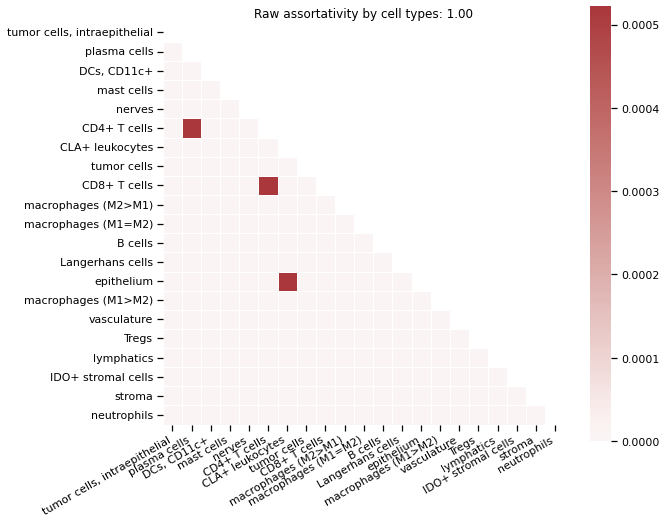

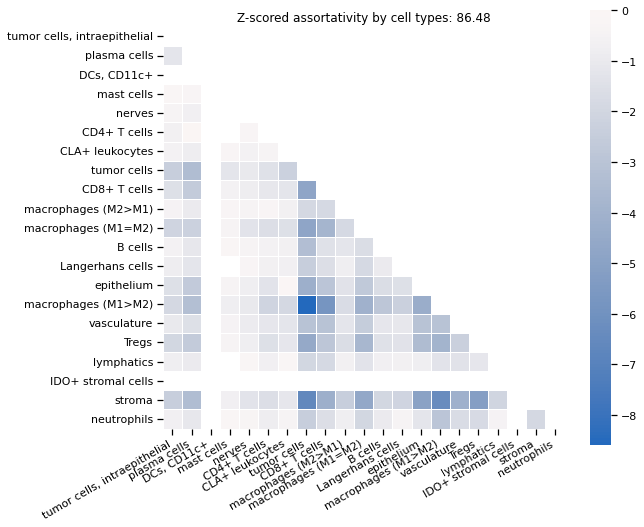

In [43]:
# Hide diagonal
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(mixmat_raw, dtype=bool))

# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

After removing highly self-assortative cell-types, we can notice that most cell types tend to avoid other cell types in this sample.

#### Assortativity and patients response

In [44]:
z_cols = [x for x in net_stats.columns if x.endswith('Z')]
z_net_stats = net_stats[z_cols]

In [45]:
# Have a look at nan values
for name, value in z_net_stats.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   36
CD4+ T cells - B cells Z                              25
CD4+ T cells - CD4+ T cells Z                         18
CD8+ T cells - B cells Z                              23
CD8+ T cells - CD4+ T cells Z                         11
CD8+ T cells - CD8+ T cells Z                         11
CLA+ leukocytes - B cells Z                           44
CLA+ leukocytes - CD4+ T cells Z                      34
CLA+ leukocytes - CD8+ T cells Z                      29
CLA+ leukocytes - CLA+ leukocytes Z                   49
DCs, CD11c+ - B cells Z                               59
DCs, CD11c+ - CD4+ T cells Z                          57
DCs, CD11c+ - CD8+ T cells Z                          56
DCs, CD11c+ - CLA+ leukocytes Z                       64
DCs, CD11c+ - DCs, CD11c+ Z                           61
epithelium - B cells Z                                19
epithelium - CD4+ T cells Z     

There are some nan values due to interactions between rare cell types that never happened.  
Can can have a first look at the sample, but it would be more informative to have a look at samples before therapy, grouping them per patient.

In [46]:
# we need to clean-up data for further analyses and visualizations
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='mixed',
    thresh=0.9,
    )

There are 6138 non finite values


/home/acoullom/Projects/mosna/mosna/mosna.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/acoullom/Projects/mosna/mosna/mosna.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan


Imputing data


/home/acoullom/Projects/mosna/mosna/mosna.py:1336: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, :] = imputer.fit_transform(data.values)


Let's add information about patients' group and time of biopsy

In [47]:
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[68 rows x 3 columns]

In [48]:
# samples 25, 36, 37, 40, 44 are missing
# pd.set_option('display.max_rows', 10)
# reg026 and reg044 not in biopsies
z_net_stats_cleaned = pd.concat([status, z_net_stats_cleaned], axis=1, join='inner').sort_values('Spots')
z_net_stats_cleaned.drop(columns=['Spots'], inplace=True)
z_net_stats_cleaned

Patients  Groups    assort Z  B cells - B cells Z  \
id                                                          
reg001         1       1   86.481544             2.629386   
reg002         1       1  114.260454            10.430811   
reg003         1       3   87.994172             8.432491   
reg004         1       3   60.334792             9.966223   
reg006         2       1   33.711063            22.017363   
...          ...     ...         ...                  ...   
reg066        14       4   80.932137             9.157481   
reg067         9       3  163.326777            25.643882   
reg068         9       3  149.933132            10.782157   
reg069        13       3  106.156883             8.258214   
reg070        13       3   39.388472            24.304822   

        CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
id                                                                
reg001                 -0.577350                       1.257237   
reg002                 -0.603023                      11.703118   
reg003                 -0.420084                      13.582717   
reg004                 -0.505398                       3.000000   
reg006                 -0.573833                       8.979478   
...                          ...                            ...   
reg066                 -0.524278                       3.481230   
reg067                 -2.759096                      22.092426   
reg068                 -0.872357                      15.575581   
reg069                 -0.808295                      15.333927   
reg070                 -0.534665                       7.208834   

        CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
id                                                                
reg001                 -1.449893                      -1.118518   
reg002                 -1.012579                       1.359538   
reg003                 -0.743311                      -1.755607   
reg004                 -0.832708                      -0.962520   
reg006                 -0.612476                      -0.229416   
...                          ...                            ...   
reg066                 -0.730425                      -0.229416   
reg067                 -2.700276                      -8.440329   
reg068                 -1.779599                      -5.195394   
reg069                 -1.704971                      -0.719195   
reg070                 -0.619521                      -0.534029   

        CD8+ T cells - CD8+ T cells Z  CLA+ leukocytes - B cells Z  ...  \
id                                                                  ...   
reg001                      24.316003                    -0.611593  ...   
reg002                      21.351729                    -0.332868  ...   
reg003                      16.072910                    -0.326346  ...   
reg004                      13.024447                    -0.302526  ...   
reg006                       8.499994                    -0.244545  ...   
...                               ...                          ...  ...   
reg066                      27.300472                    -0.326741  ...   
reg067                      38.638204                    -0.420084  ...   
reg068                      37.310093                    -0.229416  ...   
reg069                      58.023117                    -0.447860  ...   
reg070                       8.787515                    -0.242612  ...   

        vasculature - macrophages (M2>M1) Z  vasculature - mast cells Z  \
id                                                                        
reg001                            -1.271380                   -0.500000   
reg002                            -2.001541                   -0.392232   
reg003                            -1.420127                   -1.257237   
reg004                            -1.118034                   -0.466252   
reg006                            -2.001655 

In [49]:
pvals = mosna.find_DE_markers(z_net_stats_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [50]:
pvals.head(20)

pval  pval_corr
neutrophils - neutrophils Z                   0.001365   0.105538
tumor cells - lymphatics Z                    0.001365   0.105538
tumor cells - macrophages (M1=M2) Z           0.001365   0.105538
neutrophils - lymphatics Z                    0.005581   0.258941
tumor cells - IDO+ stromal cells Z            0.005581   0.258941
tumor cells - stroma Z                        0.010394   0.401909
macrophages (M1=M2) - B cells Z               0.012482   0.404514
CD4+ T cells - B cells Z                      0.015692   0.404514
macrophages (M1=M2) - lymphatics Z            0.015692   0.404514
tumor cells - B cells Z                       0.019914   0.419997
IDO+ stromal cells - CLA+ leukocytes Z        0.019914   0.419997
Tregs - macrophages (M2>M1) Z                 0.032351   0.500368
tumor cells, intraepithelial - neutrophils Z  0.032351   0.500368
vasculature - CD4+ T cells Z                  0.032351   0.500368
macrophages (M2>M1) - CD4+ T cells Z          0.032351   0.500368
tumor cells - macrophages (M1>M2) Z           0.038947   0.500414
tumor cells, intraepithelial - DCs, CD11c+ Z  0.044467   0.500414
mast cells - B cells Z                        0.044467   0.500414
macrophages (M2>M1) - lymphatics Z            0.052494   0.500414
tumor cells - CD4+ T cells Z                  0.052494   0.500414

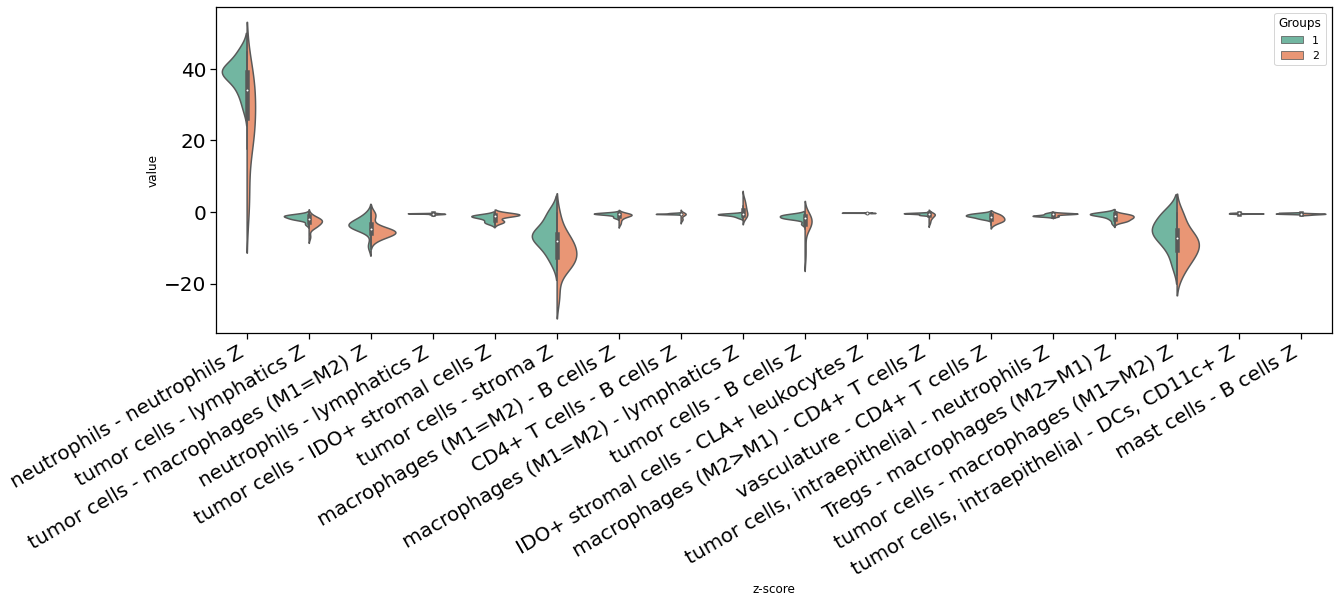

In [51]:
reload(mosna)
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

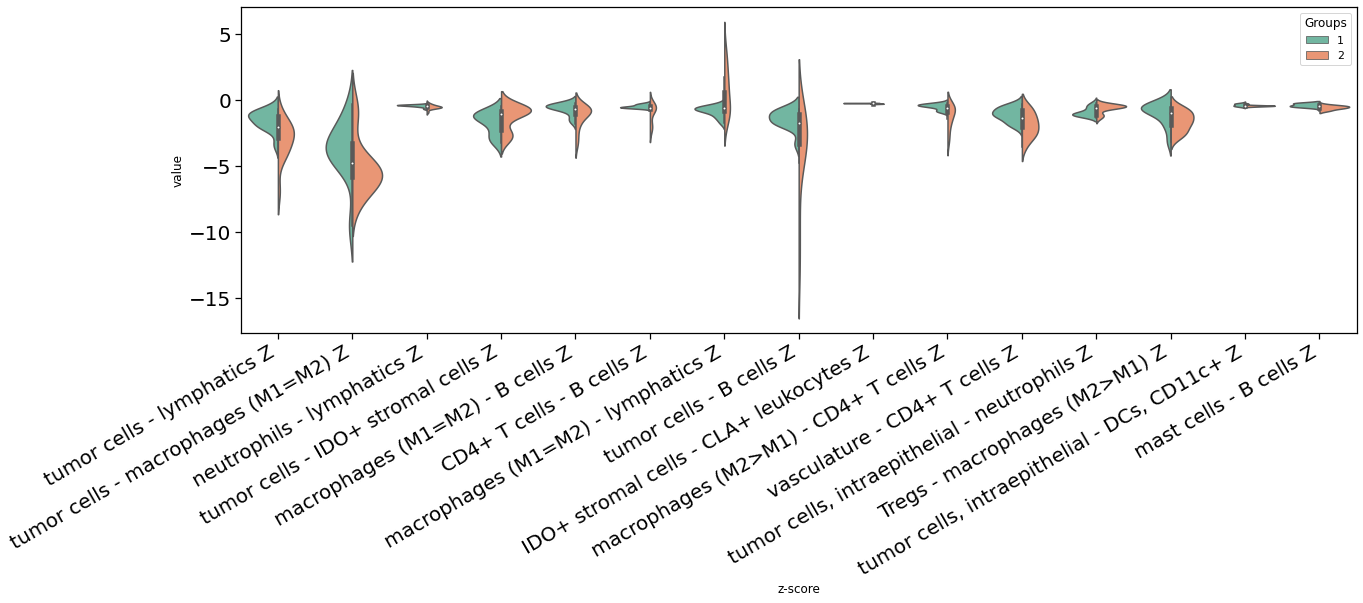

In [55]:
exclude_vars = [
    'assort Z',
    'neutrophils - neutrophils Z',
    'tumor cells - stroma Z',
    'tumor cells - macrophages (M1>M2) Z',
]
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    exclude_vars=exclude_vars,
    )

/home/acoullom/Projects/mosna/mosna/mosna.py:1658: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


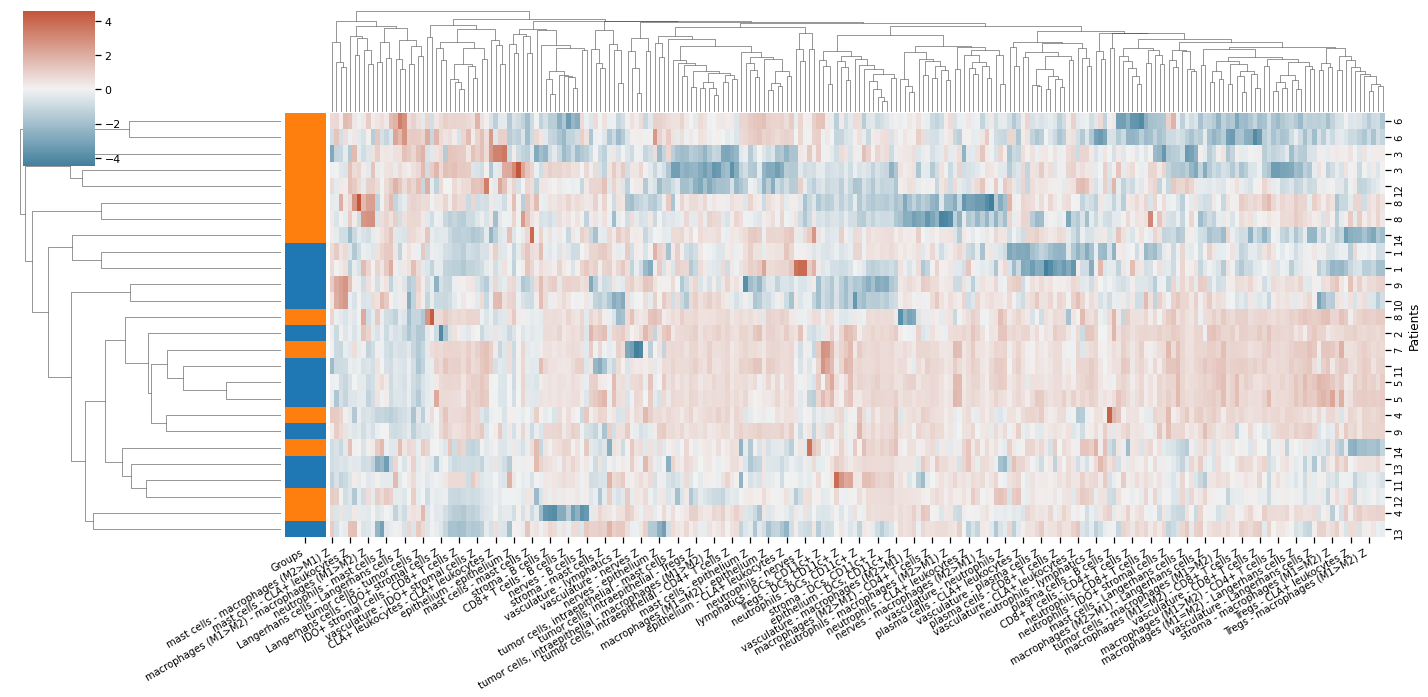

In [53]:
mosna.plot_heatmap(
    z_net_stats_cleaned, 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    skip_cols=['assort Z'],
    )

Samples are a bit clustered into consistent response groups, but it's not incredible.  
We also need to aggregate samples per patient and time of biopsy, that may help us correcting nan values and have more variables, and hopefully better clusters.

#### Samples aggregation per patient and time point.

In [56]:
z_net_stats = pd.concat([status, z_net_stats], axis=1, join='inner').sort_values('Spots')
z_net_stats.drop(columns=['Spots'], inplace=True)

In [57]:
# good news: the mean of aggregated data already ignores nans
z_net_stats_agg = z_net_stats.groupby(['Patients', 'Groups']).mean()
z_net_stats_agg

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
Patients Groups                                                              
1        1       100.370999             2.629386                 -0.590186   
         3        74.164482                  NaN                 -0.420084   
2        1        33.711063                  NaN                       NaN   
         3       119.230519            13.207449                 -0.886116   
3        2       131.069254                  NaN                 -0.358057   
         4       125.408979                  NaN                       NaN   
4        2        91.077294            62.021331                 -1.510432   
         4       112.160498            31.888787                 -0.446116   
5        1        42.735712                  NaN                       NaN   
         3        56.574130                  NaN                       NaN   
6        2       120.093252            10.525041                 -1.896658   
         4       131.253631            27.642479                  0.865644   
7        2        36.771588                  NaN                       NaN   
         4        46.697833                  NaN                 -0.229416   
8        2        96.995959            -0.420084                 -0.554082   
         4       128.205835            18.006035                  0.091617   
9        1        95.141808                  NaN                 -0.229416   
         3       118.405981            18.213019                 -1.321595   
10       1       115.445156            -0.229416                 -0.333333   
         3        75.093725                  NaN                       NaN   
11       1        58.021386                  NaN                       NaN   
         3        43.713015                  NaN                       NaN   
12       2       113.709928             1.385292                 -0.696923   
         4        91.062391            -0.229416                  0.143420   
13       1       107.901368                  NaN                 -0.407243   
         3        83.273599            22.248280                 -2.192701   
14       2        96.366276             2.064742                 -0.496393   
         4       123.623871            16.766074                  4.747037   

                 CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
Patients Groups                                                            
1        1                            6.480177                 -1.231236   
         3                            8.291358                 -0.743311   
2        1                                 NaN                       NaN   
         3                            4.250000                 -0.559426   
3        2                           22.413901                 -0.392232   
         4                           12.415850                       NaN   
4        2                                 NaN                 -1.471568   
         4                           23.963773                 -1.197954   
5        1                                 NaN                       NaN   
         3                           14.500000                       NaN   
6        2                           44.166394                 -3.197034   
         4                           36.560969                 -2.114154   
7        2                                 NaN                       NaN   
         4                                 NaN                 -0.333333   
8        2                            7.898329                 -0.440170   
         4                           14.166667                 -2.184304   
9        1                           17.258220                 -0.364708   
         3                            9.228647                 -1.671726   
10       1                           13.535528                 -0.745356   
         3                                 NaN                 -0.500000   
11    

In [58]:
# Have a look at nan values
for name, value in z_net_stats_agg.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   13
CD4+ T cells - B cells Z                              8
CD4+ T cells - CD4+ T cells Z                         7
CD8+ T cells - B cells Z                              8
CD8+ T cells - CD4+ T cells Z                         3
CD8+ T cells - CD8+ T cells Z                         5
CLA+ leukocytes - B cells Z                           16
CLA+ leukocytes - CD4+ T cells Z                      12
CLA+ leukocytes - CD8+ T cells Z                      10
CLA+ leukocytes - CLA+ leukocytes Z                   20
DCs, CD11c+ - B cells Z                               24
DCs, CD11c+ - CD4+ T cells Z                          21
DCs, CD11c+ - CD8+ T cells Z                          22
DCs, CD11c+ - CLA+ leukocytes Z                       25
DCs, CD11c+ - DCs, CD11c+ Z                           25
epithelium - B cells Z                                4
epithelium - CD4+ T cells Z           

In [59]:
z_net_agg_cleaned, select_finite = mosna.clean_data(
    z_net_stats_agg, 
    method='mixed',
    thresh=0.9,
    )

There are 2006 non finite values
Imputing data


In [60]:
pvals = mosna.find_DE_markers(z_net_agg_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [61]:
pvals.head(20)

pval  pval_corr
mast cells - B cells Z               0.000583   0.134615
vasculature - CD4+ T cells Z         0.053030   0.992788
macrophages (M1=M2) - lymphatics Z   0.053030   0.992788
CLA+ leukocytes - B cells Z          0.053030   0.992788
tumor cells - macrophages (M1=M2) Z  0.053030   0.992788
tumor cells - CD4+ T cells Z         0.053030   0.992788
neutrophils - macrophages (M2>M1) Z  0.053030   0.992788
tumor cells - lymphatics Z           0.053030   0.992788
tumor cells - Tregs Z                0.212121   0.992788
Langerhans cells - CD8+ T cells Z    0.212121   0.992788
tumor cells - stroma Z               0.212121   0.992788
plasma cells - lymphatics Z          0.212121   0.992788
tumor cells - macrophages (M1>M2) Z  0.212121   0.992788
lymphatics - CD4+ T cells Z          0.212121   0.992788
nerves - CD4+ T cells Z              0.212121   0.992788
tumor cells - CD8+ T cells Z         0.212121   0.992788
plasma cells - IDO+ stromal cells Z  0.212121   0.992788
nerves - CD8+ T cells Z              0.212121   0.992788
Tregs - Tregs Z                      0.212121   0.992788
Tregs - Langerhans cells Z           0.212121   0.992788

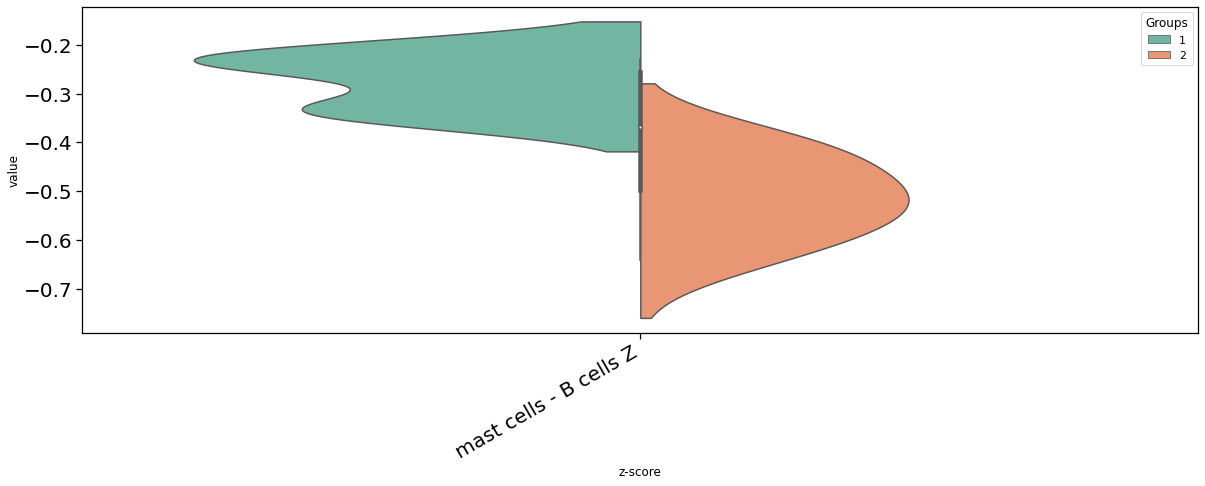

In [62]:
fig, ax = mosna.plot_distrib_groups(
    z_net_agg_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

/home/acoullom/Projects/mosna/mosna/mosna.py:1658: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


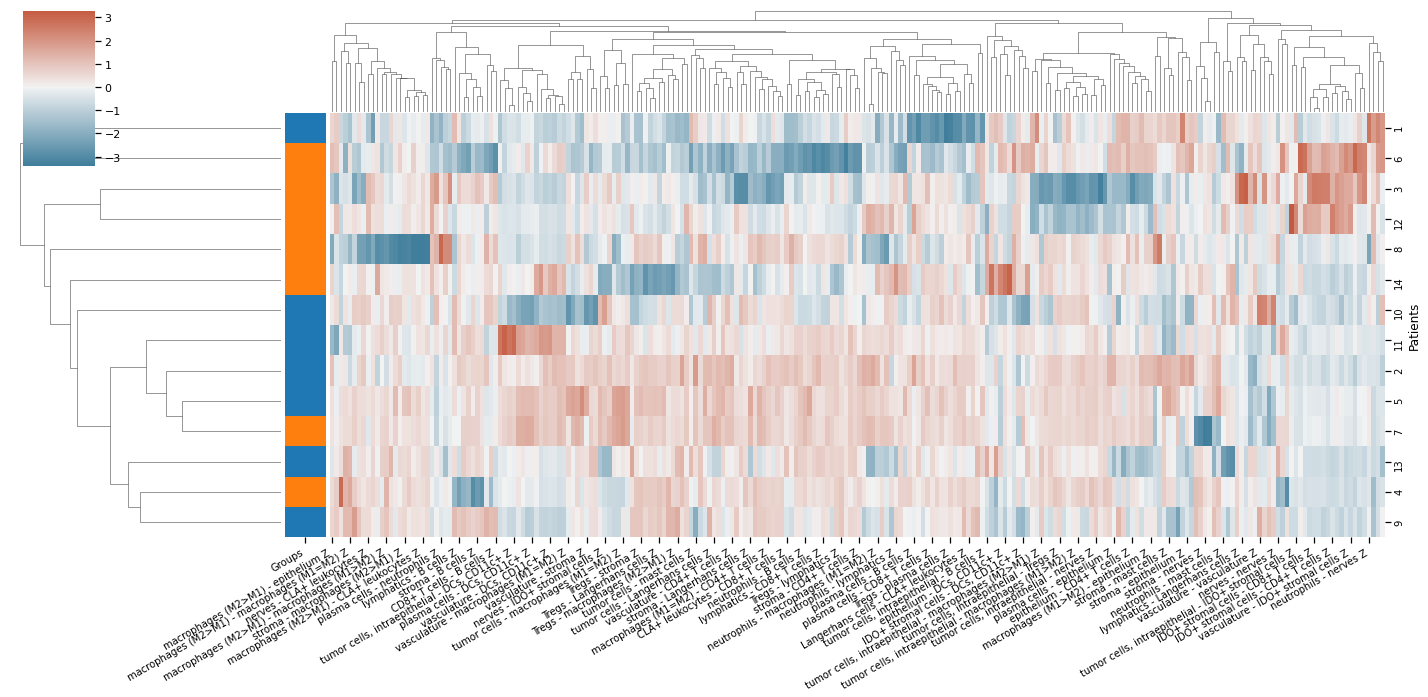

In [63]:
mosna.plot_heatmap(
    z_net_agg_cleaned.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

In [65]:
# # use the most statistically relevant variable separating groups
# # Note: that's to have a clue, do not use this method for real,
# # it's a tautology!

# nb_vars = np.sum(pvals['pval'] <= 0.05)
# nb_vars = min(nb_vars, 20)
# marker_vars = pvals.sort_values(by='pval', ascending=True).head(nb_vars).index.tolist()

# mosna.plot_heatmap(
#     z_net_agg_cleaned[marker_vars].reset_index(), 
#     obs_labels='Patients', 
#     group_var='Groups', 
#     groups=[1, 2],
#     figsize=(10, 10),
#     )

### Marker-positive cells interactions

We can also compute the mixing matrix and assortativity between marker-positive cells.

## Cellular neighborhoods

The mixing matrix and assortativity give us information about the global network organization.  
Here we will see how to use the *Neighbors Aggregation Statistics* method to find local "cellular communities", or "neighborhoods", or "niches", that can be relevant to understand disease progression or response to therapies.  

### First order neighbors, mean and std

In [20]:
order = 1
var_type = 'cell-types'
stat_names = 'mean-std'
aggreg_vars = cell_type_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [21]:
processed_dir = Path('../data/processed/CODEX_CTCL')
reconstruction_dir = processed_dir / "all_samples_networks_xy_trim_dist-200_solitary-0"
nas_dir = reconstruction_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

In [22]:
# attrib_all = obj[cell_type_cols]
X = obj[aggreg_vars].values
edges_all = pd.read_csv(reconstruction_dir/ 'sample_all-edges.csv')
pairs = edges_all.values

In [26]:
var_aggreg = mosna.aggregate_k_neighbors(
    X=X,
    pairs=pairs,
    order=order,
    var_names=aggreg_vars,
)

Trimmimg additonnal columns in `pairs`


In [27]:
var_aggreg.to_csv(nas_dir / f'aggregation_statistics.csv', index=False)

In [ ]:
# Uncomment to load already computed NAS
var_aggreg = pd.read_csv(nas_dir / f'aggregation_statistics.csv')

In [31]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer = umap.UMAP(
    random_state=0,
    n_neighbors=n_neighbors,
    metric=metric,
    min_dist=min_dist,
    # we don't modify the other parameters
    # spread=1.0,
    # set_op_mix_ratio=1.0,
    # local_connectivity=1.0,
    # repulsion_strength=1.0,
    # negative_sample_rate=5,
    # transform_queue_size=4.0,
    )
embedding = reducer.fit_transform(var_aggreg)
reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
# save reduced coordinates
np.save(nas_dir / (reducer_name + '.npy'), embedding, allow_pickle=False, fix_imports=False)
# save the reducer object
joblib.dump(reducer, nas_dir / (reducer_name + '.pkl'))
embedding.shape

(117170, 2)

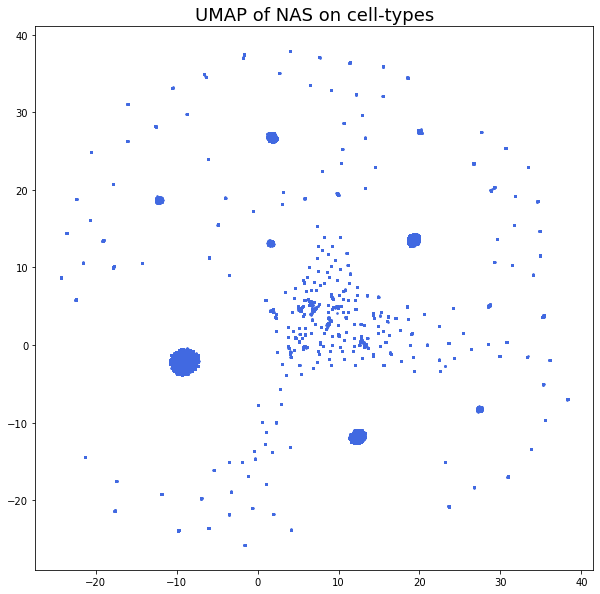

In [34]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Screen NAS parameters

In [ ]:
from importlib import reload
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
parallel_dim = 'max'
parallel_clustering = 4
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'
save_dir = 'test-parallel'

mosna.screen_nas_parameters(X, pairs, markers, orders, dim_clusts, min_cluster_sizes, processed_dir, save_dir=save_dir, soft_clustering=True, 
                            opt_str=opt_str, parallel_dim=parallel_dim, parallel_clustering=parallel_clustering, memory_limit='800GB')


#### Clusters visualization

dim_clust: 2
    min_cluster_size: 100


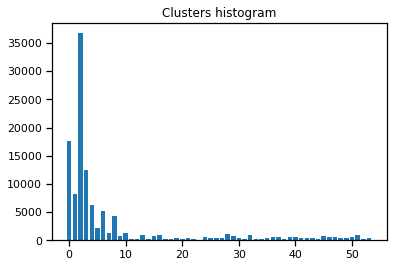

No handles with labels found to put in legend.


        sample: 1


In [188]:
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'

mosna.plot_screened_parameters(obj, cell_pos_cols, cell_type_cols, orders, dim_clusts, processed_dir,
                               min_cluster_sizes, all_edges='all_samples_networks', sampling=False, var_type=None, 
                               downsample=False, aggreg_dir=None, load_dir=None, save_dir=None, opt_str=opt_str)

### Data transformation

In [23]:
order = 1
var_type = 'markers'
stat_names = 'mean-std'
aggreg_vars = marker_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [24]:
processed_dir = Path('../data/processed/CODEX_CTCL')
reconstruction_dir = processed_dir / "all_samples_networks_xy_trim_dist-200_solitary-0"
nas_dir = reconstruction_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

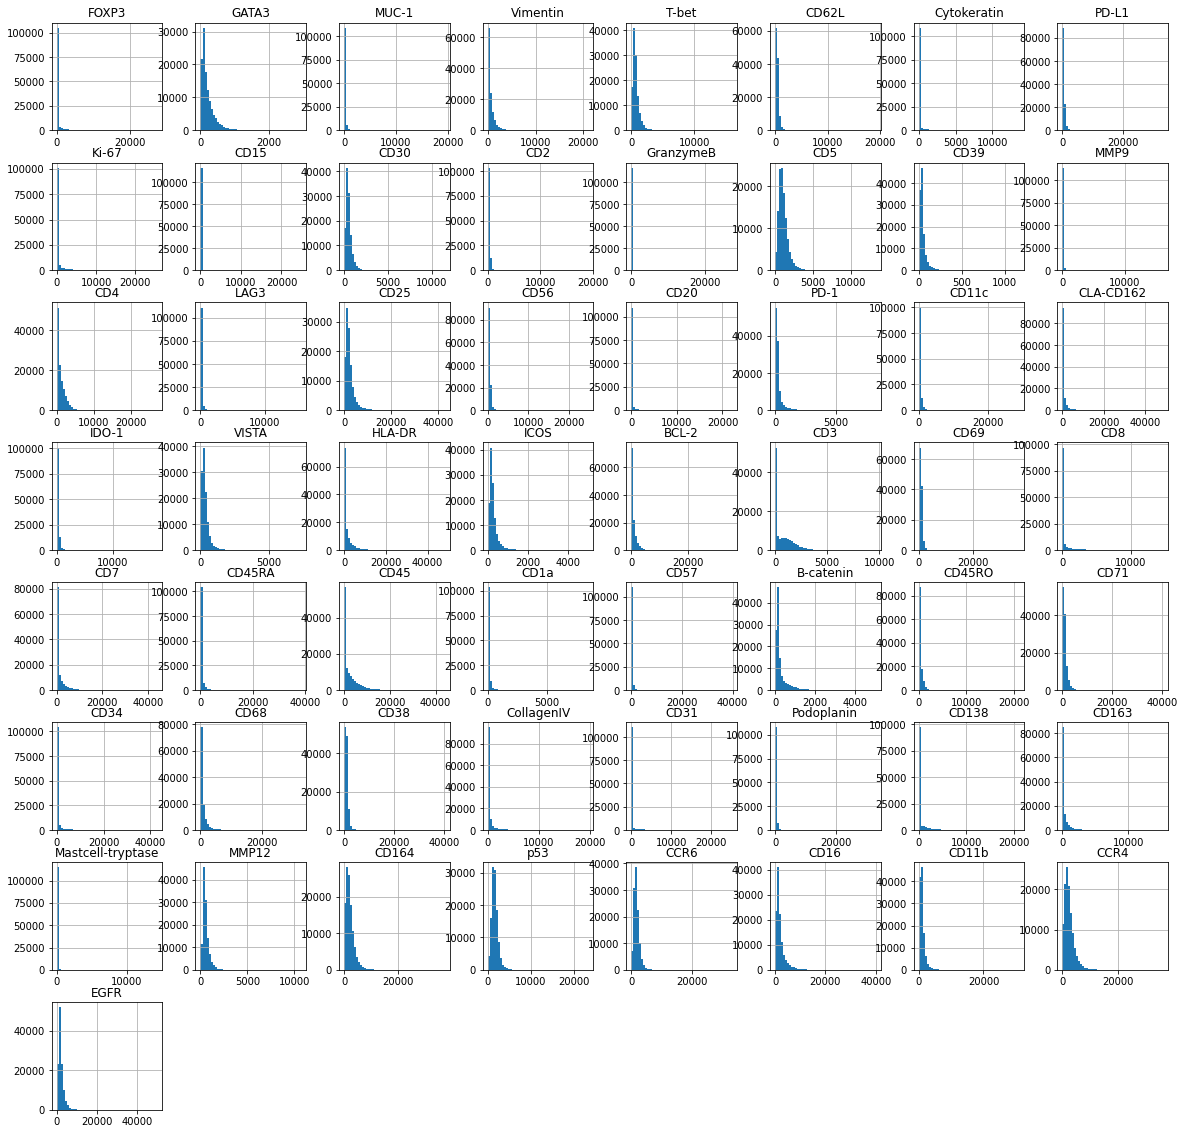

In [25]:
obj[aggreg_vars].hist(bins=50, figsize=(20, 20));

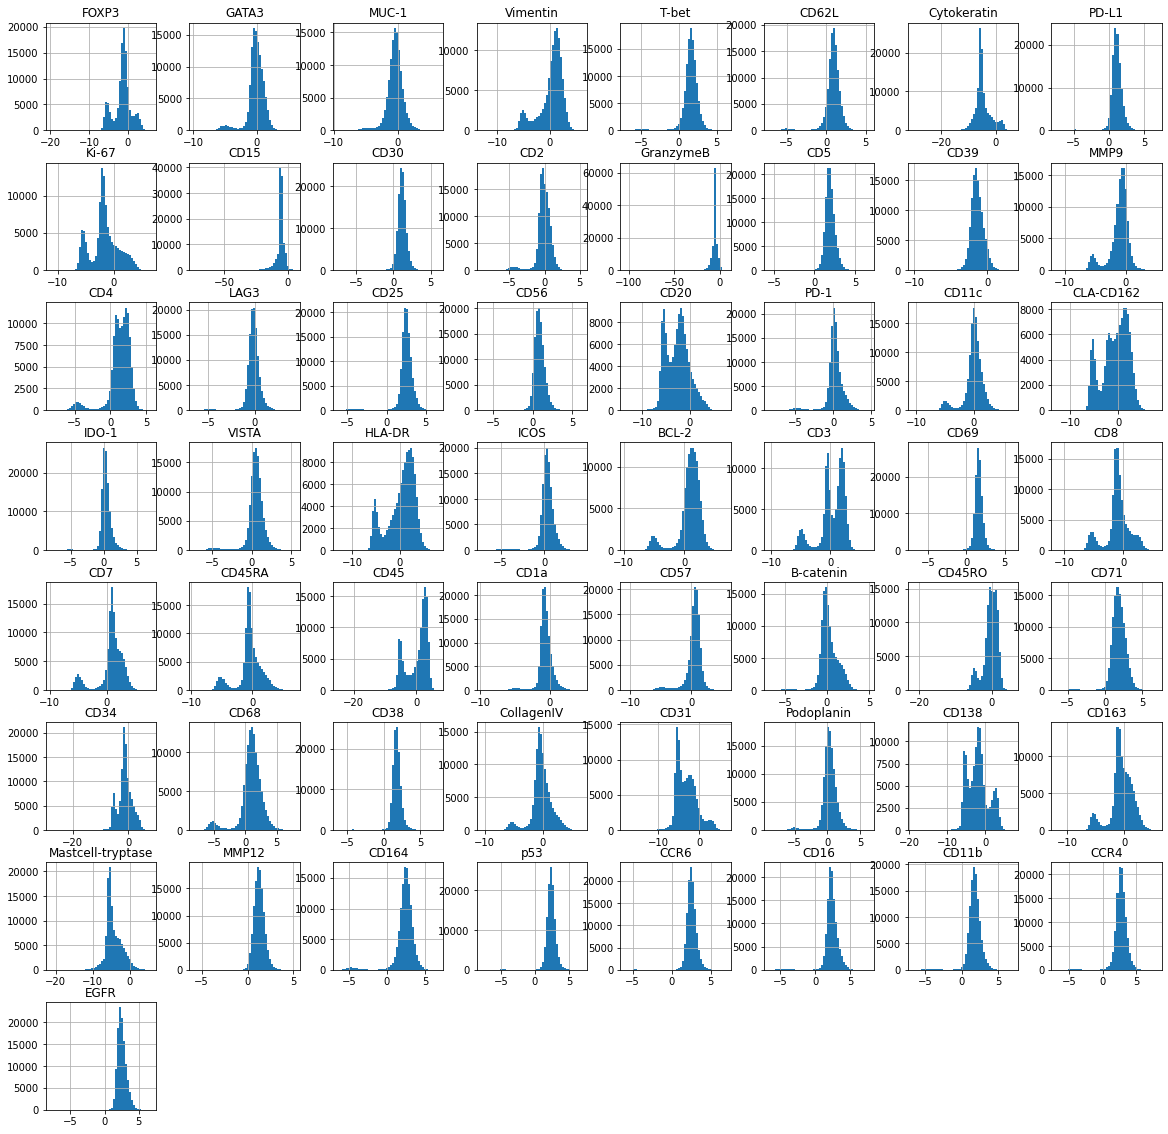

In [26]:
X = obj[aggreg_vars].values
X[X == 0] = X.max() / 100000

X_clr = cs.clr(cs.closure(X))
aggreg_vars_clr = obj[aggreg_vars].copy()
aggreg_vars_clr.loc[:, :] = X_clr
aggreg_vars_clr.hist(bins=50, figsize=(20, 20));

In [27]:
file_path = nas_dir / f'aggregation_statistics.csv'

if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Computing Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [66]:
n_neighbors = 15
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if file_path.append_suffix('.npy').is_file():
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(file_path.append_suffix('.npy'))
    reducer = joblib.load(file_path.append_suffix('.pkl'))
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(file_path.append_suffix('.npy'), embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, file_path.append_suffix('.pkl').as_posix());


Loading reducer object and reduced coordinates


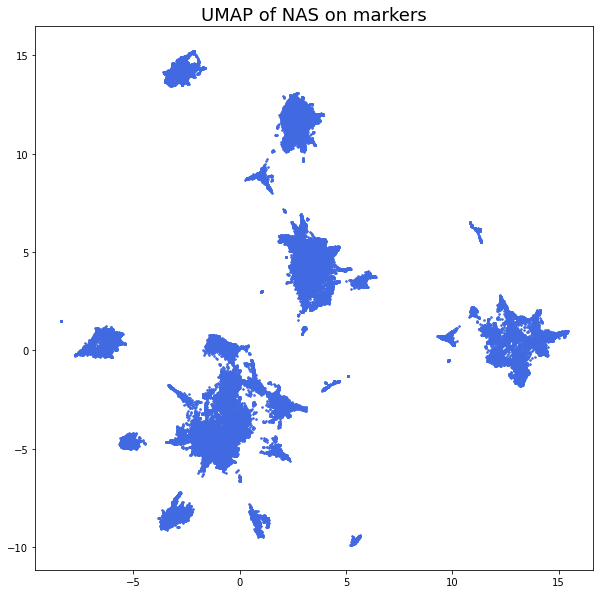

In [67]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [83]:
import igraph as ig
import leidenalg as la

In [ ]:
dim_clusts = 2
k_cluster = 15
resolution_parameter = 0.005
other_str = ''
force_recompute = True

cluster_dir = nas_dir / f"clusterer-leiden_dim_clusts-{dim_clusts}_n_neighbors-{k_cluster}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"partition-{'RBConfigurationVertexPartition'}_resolution-{resolution_parameter}{other_str}"
file_path = cluster_dir / clusterer_name

if file_path.append_suffix('.npy').is_file() and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(file_path.append_suffix('.npy'))
    clusterer = joblib.load(file_path.append_suffix('.pkl'))
    nb_clust = cluster_labels.max()
else:
    print("Performing clustering")
    # build knn graph
    nas_coords = embedding  # the UMAP reduced coordinates
    nas_pairs = ty.build_knn(nas_coords, k=k_cluster)
    # convert into iGraph object
    G = ty.to_iGraph(nas_coords, nas_pairs)
    # perform clustering
    partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=resolution_parameter)
    cluster_labels = np.array(partition.membership)
    nb_clust = cluster_labels.max()
    print(f"Found {nb_clust} clusters")
    # save cluster labels
    np.save(file_path.append_suffix('.npy'), cluster_labels, allow_pickle=False, fix_imports=False)
    # save the iGraph object
    joblib.dump(G, file_path.append_suffix('.ig').as_posix());

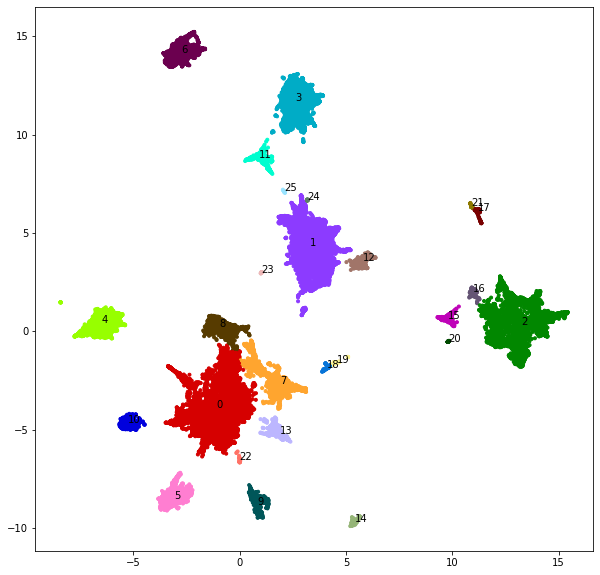

In [89]:
embed_viz = embedding

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id
    x_mean = embed_viz[clust_targ, 0].mean()
    y_mean = embed_viz[clust_targ, 1].mean()
    plt.text(x_mean, y_mean, str(clust_id))

In [90]:
# Merge some small adjacent clusters
merge_dict = {
    19: 18,
    21: 17,
    24: 1,
    # 23: 1,
    # 25: 1,
}
for old, new in merge_dict.items():
    cluster_labels[cluster_labels == old] = new
    
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)


In [99]:
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)
decreasing_counts_ids = np.argsort(class_count)[::-1]
new_ids = np.arange(len(class_id))[decreasing_counts_ids]
for old, new in zip(class_id, new_ids):
    cluster_labels[cluster_labels == old] = new

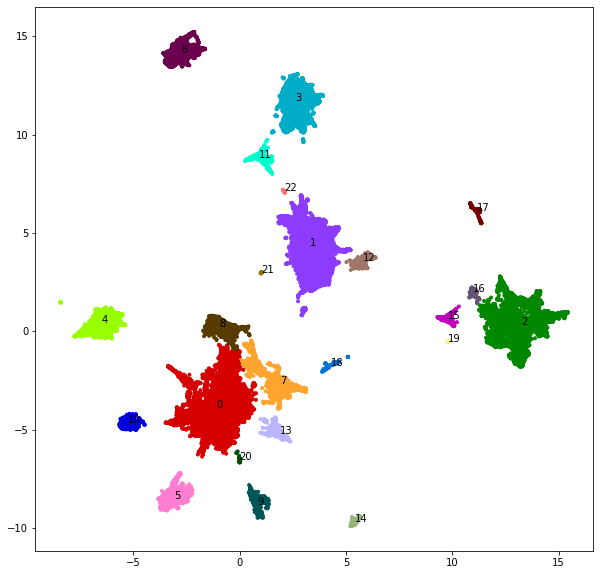

In [100]:
embed_viz = embedding

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id
    x_mean = embed_viz[clust_targ, 0].mean()
    y_mean = embed_viz[clust_targ, 1].mean()
    plt.text(x_mean, y_mean, str(clust_id))

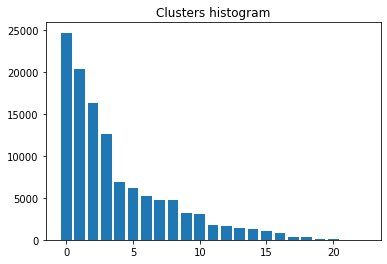

In [103]:
class_id, class_count = np.unique(cluster_labels, return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

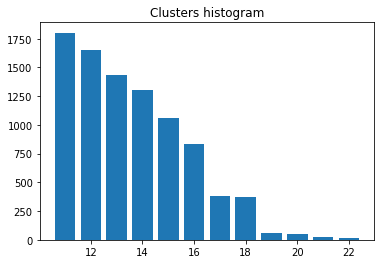

In [104]:
class_id, class_count = np.unique(cluster_labels[cluster_labels > 10], return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

In [161]:
other_str = 'manual-cleaning'

clusterer_name = f"partition-{'RBConfigurationVertexPartition'}_resolution-{resolution_parameter}{other_str}"
file_path = cluster_dir / clusterer_name

# save cluster labels
np.save(file_path.append_suffix('.npy'), cluster_labels, allow_pickle=False, fix_imports=False)

In [28]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if file_path.append_suffix('.npy').is_file():
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(file_path.append_suffix('.npy'))
    reducer = joblib.load(file_path.append_suffix('.pkl'))
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(file_path.append_suffix('.npy'), embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, file_path.append_suffix('.pkl').as_posix());


Loading reducer object and reduced coordinates


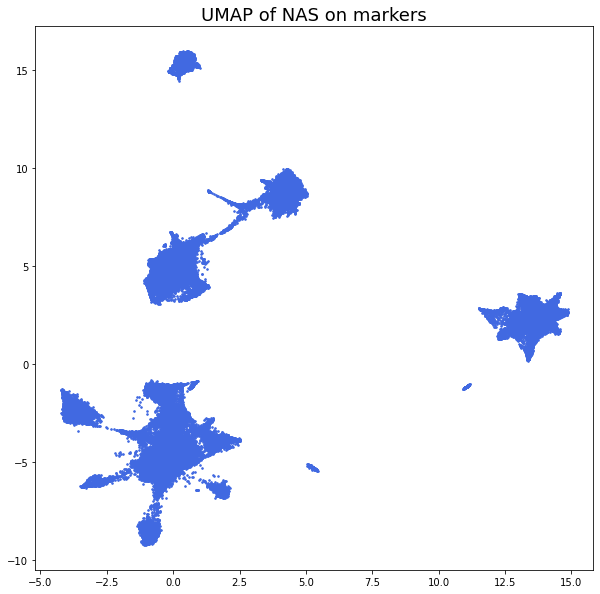

In [29]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [58]:
dim_clusts = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
# soft_clustering = False or 'knn' or 'proba'
soft_clustering = False 
parallel_clustering = 16
force_recompute = False

cluster_dir = nas_dir / f"clusterer-HDBSCAN_dim_clusts-{dim_clusts}_min_samples-{min_samples}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"min_cluster_size-{min_cluster_size}_epsilon-{epsilon}_soft_clustering-{soft_clustering}"
file_path = cluster_dir / clusterer_name
cache_dir = cluster_dir / 'memory_cache'

if file_path.append_suffix('.npy').is_file() and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(file_path.append_suffix('.npy'))
    clusterer = joblib.load(file_path.append_suffix('.pkl'))
    nb_clust = cluster_labels.max() # + 1
else:
    print("Performing clustering")
    # select embedded data
    embed_clust = embedding
    # Clustering
    start = time()
    if soft_clustering is False or soft_clustering == 'knn':
        clusterer = hdbscan.HDBSCAN( 
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        cluster_labels = clusterer.labels_

        # replace points with label -1 to closest labels in the UMAP space
        if soft_clustering == 'knn':
            cluster_labels = cluster_labels.astype(float)
            # set labels -1 to nan
            select = cluster_labels == -1
            cluster_labels[select] = np.nan
            # perform data imputation
            imputer = KNNImputer(n_neighbors=5, weights="distance")
            cluster_labels = imputer.fit_transform(cluster_labels.reshape(-1, 1)).flatten()
            # set to 0/1 the imputed categorical variables
            cluster_labels = cluster_labels.round().astype(int)
            
    # use max proba of labels different from -1
    # it can lead to very different clustering for unknow reason so far
    elif soft_clustering == 'proba':
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples, 
            cluster_selection_epsilon=epsilon,
            prediction_data=True, 
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        if len(soft_clusters.shape) > 1:
            # set to 0 the probability of being noise
            if -1 in np.unique(clusterer.labels_):
                soft_clusters[:, 0] = 0
            cluster_labels = soft_clusters.argmax(axis=1)
        else:
            cluster_labels = soft_clusters

    end = time()
    duration = end - start
    nb_clust = cluster_labels.max() # + 1
    print("HDBSCAN has detected {} clusters in {:.2f}s".format(nb_clust, duration))
    # save cluster labels
    np.save(file_path.append_suffix('.npy'), cluster_labels, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(clusterer, file_path.append_suffix('.pkl').as_posix());
nb_clust = cluster_labels.max() # + 1

Performing clustering
HDBSCAN has detected 10 clusters in 5.33s


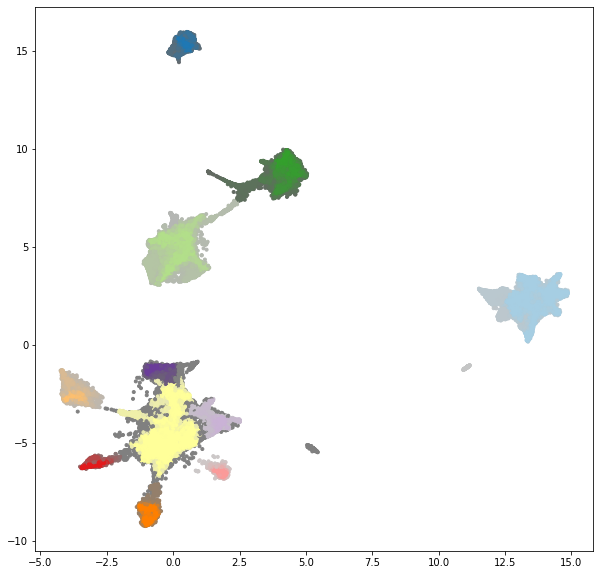

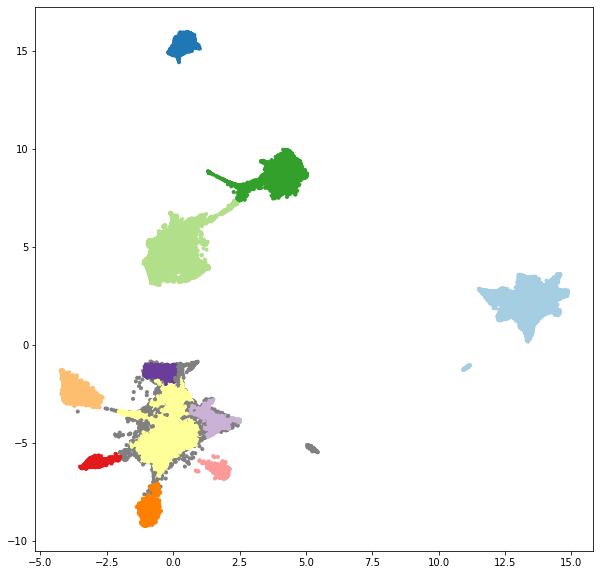

In [59]:
embed_viz = embedding

# make a cohort-wide cmap
clusters_cmap = cc.palette["glasbey_category10"]
# make color mapper
# series to sort by decreasing order
uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
n_colors = len(clusters_cmap)
labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
# make list of colors
labels_colors = [labels_color_mapper[x] for x in cluster_labels]
labels_colors = pd.Series(labels_colors)

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_member_colors, marker='.');

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks good, let's add soft clustering.

In [62]:
dim_clusts = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
# soft_clustering = False or 'knn' or 'proba'
soft_clustering = 'knn' 
parallel_clustering = 16
force_recompute = False

cluster_dir = nas_dir / f"clusterer-HDBSCAN_dim_clusts-{dim_clusts}_min_samples-{min_samples}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"min_cluster_size-{min_cluster_size}_epsilon-{epsilon}_soft_clustering-{soft_clustering}"
file_path = cluster_dir / clusterer_name
cache_dir = cluster_dir / 'memory_cache'

if file_path.append_suffix('.npy').is_file() and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(file_path.append_suffix('.npy'))
    clusterer = joblib.load(file_path.append_suffix('.pkl'))
    nb_clust = cluster_labels.max() # + 1
else:
    print("Performing clustering")
    # select embedded data
    embed_clust = embedding
    # Clustering
    start = time()
    if soft_clustering is False or soft_clustering == 'knn':
        clusterer = hdbscan.HDBSCAN( 
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        cluster_labels = clusterer.labels_

        # replace points with label -1 to closest labels in the UMAP space
        if soft_clustering == 'knn':
            cluster_labels = cluster_labels.astype(float)
            # set labels -1 to nan
            select = cluster_labels == -1
            cluster_labels[select] = np.nan
            # perform data imputation
            imputer = KNNImputer(n_neighbors=5, weights="distance")
            cluster_labels = imputer.fit_transform(cluster_labels.reshape(-1, 1)).flatten()
            # set to 0/1 the imputed categorical variables
            cluster_labels = cluster_labels.round().astype(int)
            
    # use max proba of labels different from -1
    # it can lead to very different clustering for unknow reason so far
    elif soft_clustering == 'proba':
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples, 
            cluster_selection_epsilon=epsilon,
            prediction_data=True, 
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        if len(soft_clusters.shape) > 1:
            # set to 0 the probability of being noise
            if -1 in np.unique(clusterer.labels_):
                soft_clusters[:, 0] = 0
            cluster_labels = soft_clusters.argmax(axis=1)
        else:
            cluster_labels = soft_clusters

    end = time()
    duration = end - start
    nb_clust = cluster_labels.max() # + 1
    print("HDBSCAN has detected {} clusters in {:.2f}s".format(nb_clust, duration))
    # save cluster labels
    np.save(file_path.append_suffix('.npy'), cluster_labels, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(clusterer, file_path.append_suffix('.pkl').as_posix());
nb_clust = cluster_labels.max() # + 1

Performing clustering
HDBSCAN has detected 10 clusters in 17.62s


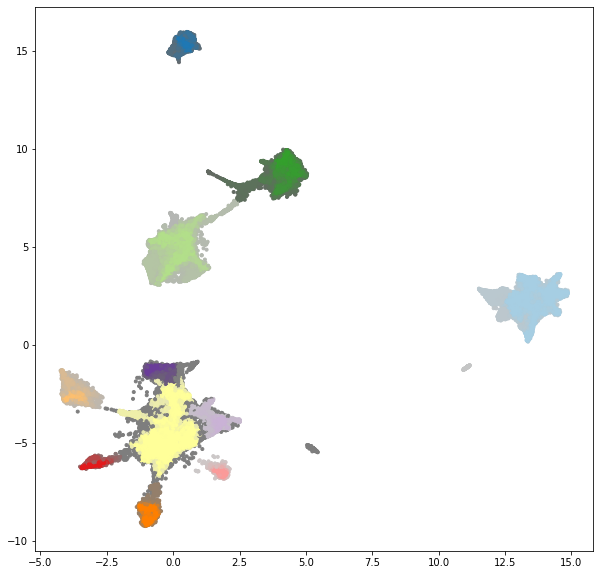

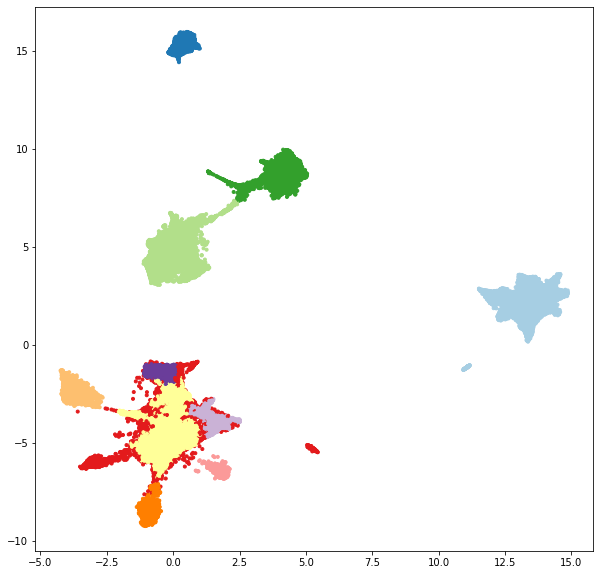

In [63]:
embed_viz = embedding

# make a cohort-wide cmap
clusters_cmap = cc.palette["glasbey_category10"]
# make color mapper
# series to sort by decreasing order
uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
n_colors = len(clusters_cmap)
labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
# make list of colors
labels_colors = [labels_color_mapper[x] for x in cluster_labels]
labels_colors = pd.Series(labels_colors)

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_member_colors, marker='.');

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

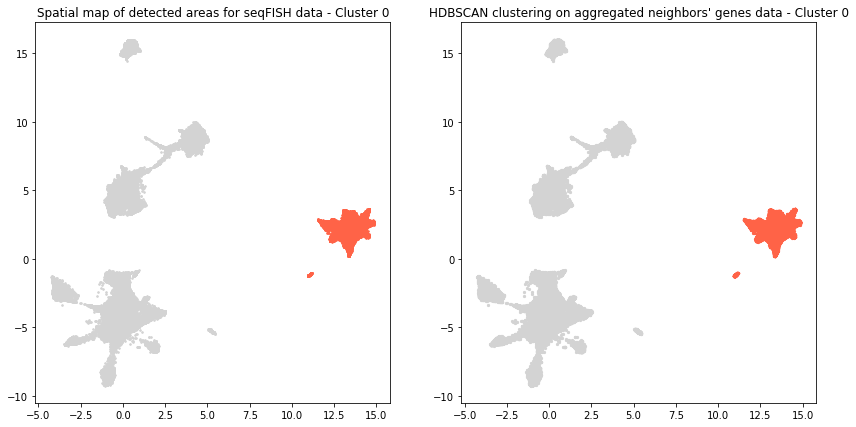

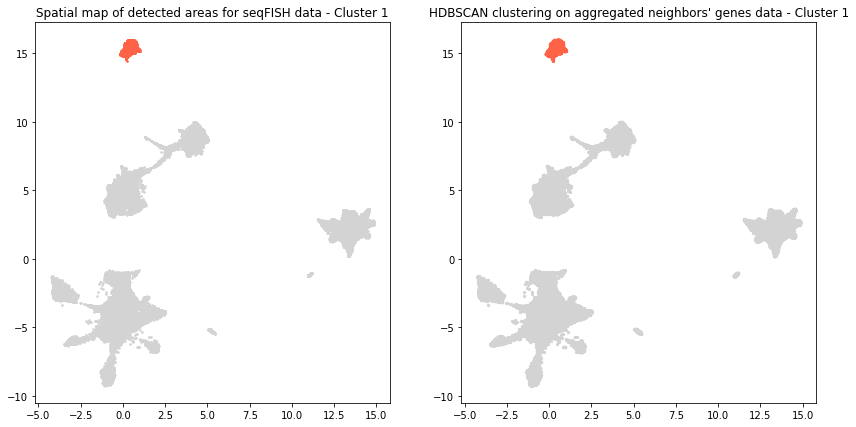

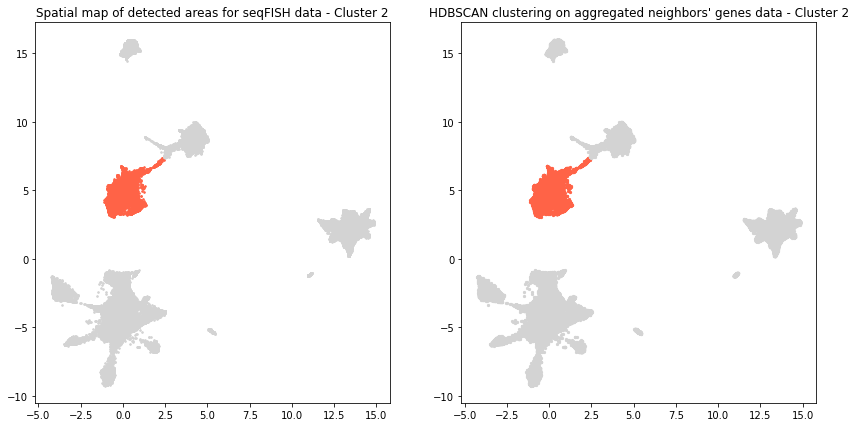

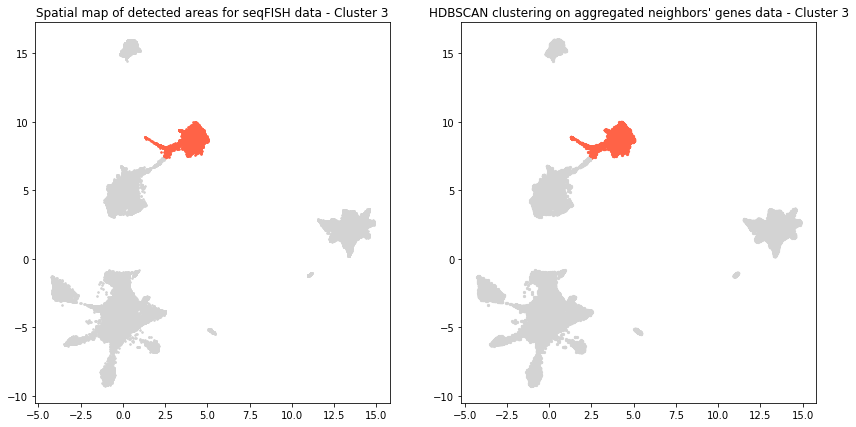

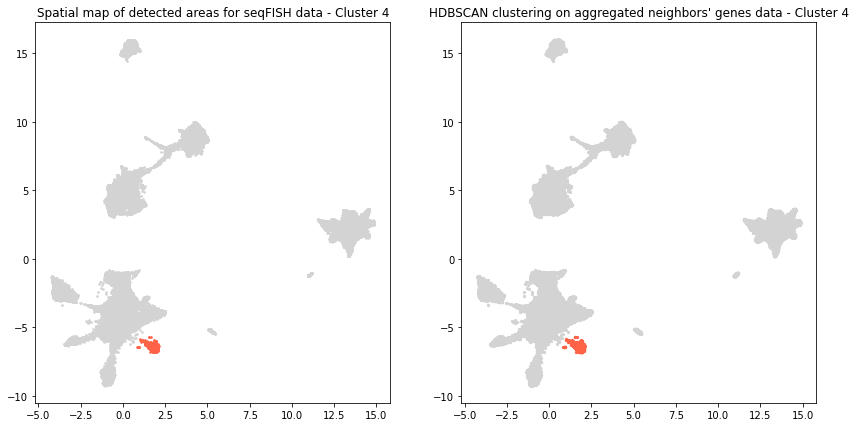

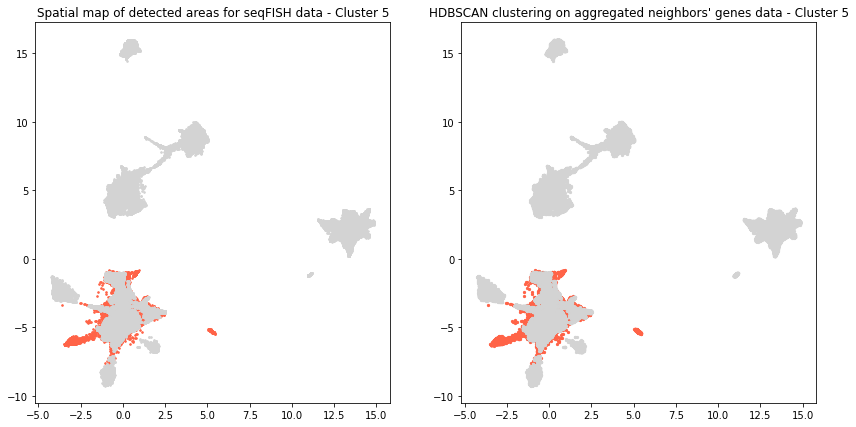

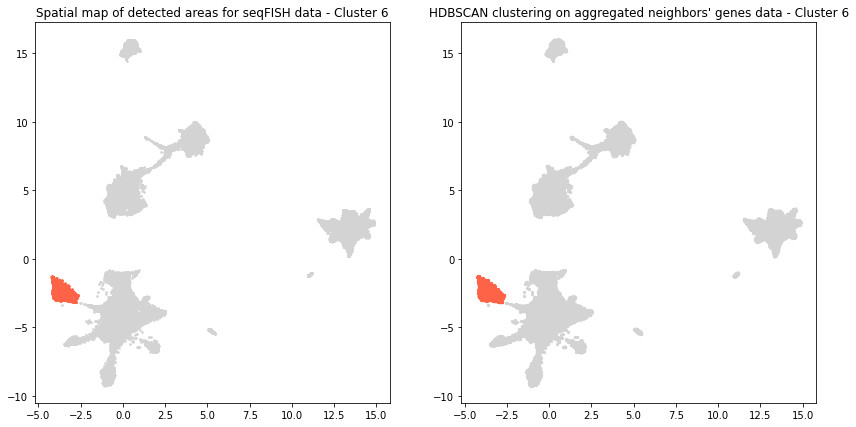

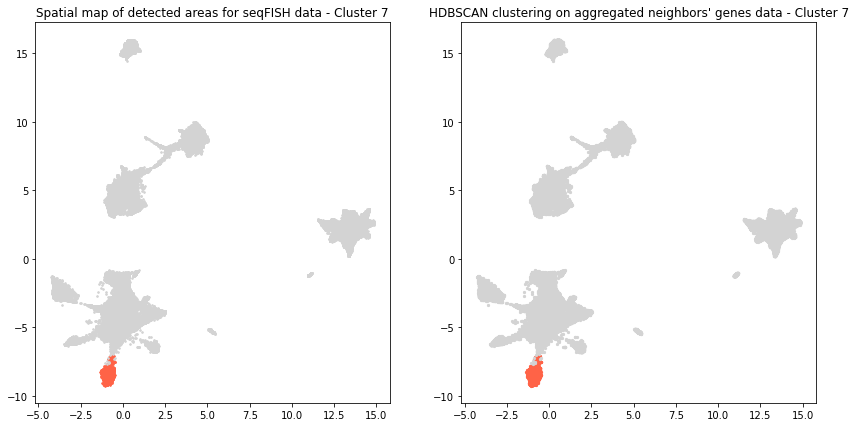

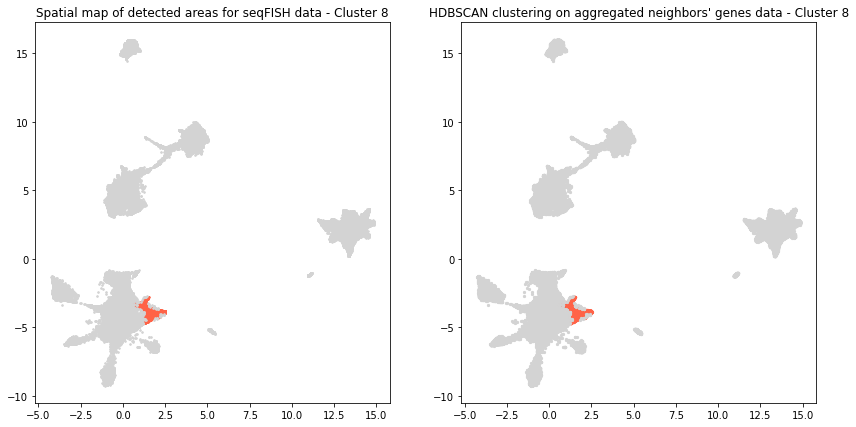

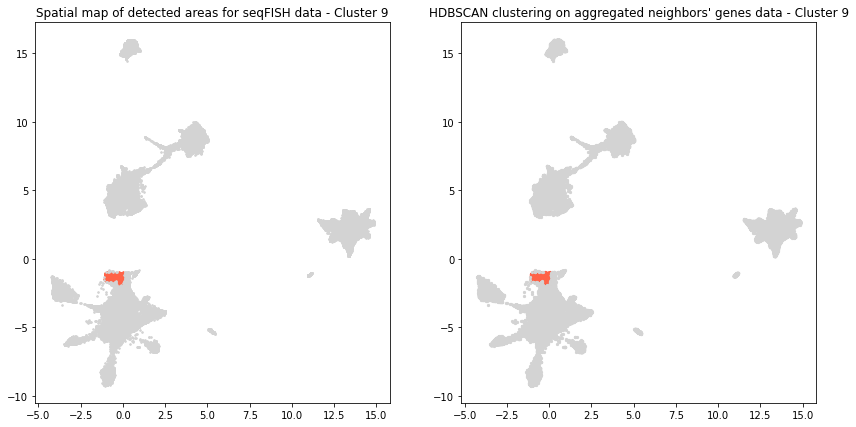

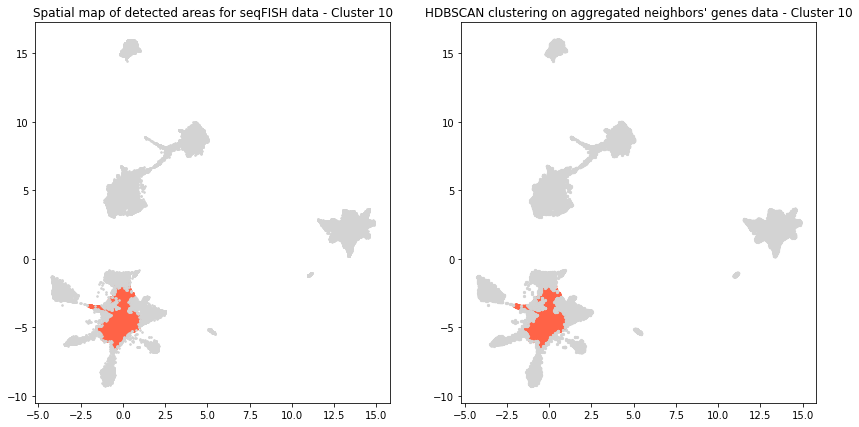

In [64]:
for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id  # cluster of interest (target)
    clust_comp = cluster_labels != clust_id  # cluster(s) we compare with

    fig, ax = plt.subplots(1, 2, figsize=(14,7), tight_layout=False)

    ax[0].scatter(embed_viz[clust_targ,0], embed_viz[clust_targ,1], c='tomato', marker=marker, s=size_points)
    ax[0].scatter(embed_viz[clust_comp,0], embed_viz[clust_comp,1], c='lightgrey', marker=marker, s=size_points)
    ax[0].set_title('Spatial map of detected areas for seqFISH data - Cluster '+str(clust_id), fontsize=12);
    
    ax[1].scatter(embed_viz[clust_targ, 0], embed_viz[clust_targ, 1], s=5, c='tomato');
    ax[1].scatter(embed_viz[clust_comp, 0], embed_viz[clust_comp, 1], s=5, c='lightgrey');
    ax[1].set_title("HDBSCAN clustering on aggregated neighbors' genes data - Cluster "+str(clust_id), fontsize=12);
    plt.show()

It seems impossible to ave a partition that makes sense, there are really wrong cluster labeling.

#### Leiden clustering using Scanpy

In [78]:
# Leiden requires an iGraph object
# we could use a network produced by UMAP
# but it's more straightforward to use Scanpy

import anndata as ad
import scanpy as sc

adata = ad.AnnData(X_clr)
adata.var_names = aggreg_vars
adata

/tmp/ipykernel_19796/2195255581.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X_clr)


AnnData object with n_obs × n_vars = 117170 × 57

In [ ]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

In [ ]:
# Embedding the neighborhood graph
sc.tl.umap(adata)

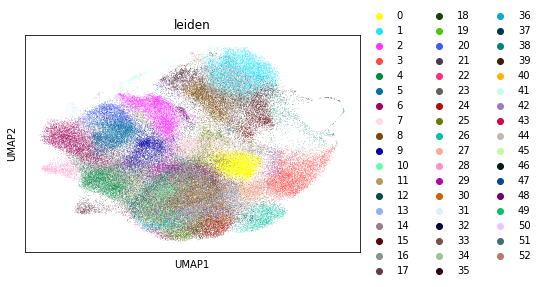

In [ ]:
# Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=2)
sc.pl.umap(adata, color=['leiden'])

The UMAP projected data doesn't look promising.  
Let's try our own UMAP projection.

#### Leiden clustering using scikit knn on UMAP data

In [30]:
import igraph as ig
import leidenalg as la

k_cluster = 15
nas_coords = embedding
nas_pairs = ty.build_knn(nas_coords, k=k_cluster)

G = ty.to_iGraph(nas_coords, nas_pairs, attributes=None)

partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=0.01)
# partition = la.find_partition(G, la.CPMVertexPartition, resolution_parameter=0.00001)
cluster_labels = np.array(partition.membership)
nb_clust = cluster_labels.max()
print(f"Found {nb_clust} clusters")

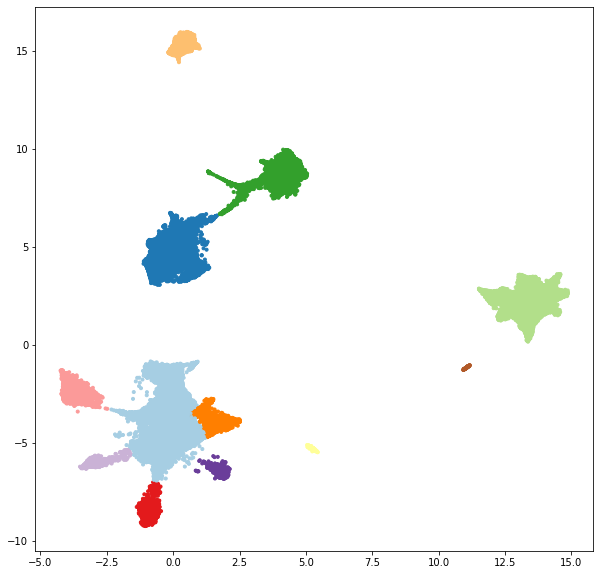

In [65]:
embed_viz = embedding

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks great, we'll do the same with n_neighbors=15, see above.

#### On markers, order 2

In [40]:
order = 2
nas_dir = reconstruction_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

file_path = nas_dir / f'aggregation_statistics.csv'
if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Compouting Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [ ]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if file_path.append_suffix('.npy').is_file():
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(file_path.append_suffix('.npy'))
    reducer = joblib.load(file_path.append_suffix('.pkl'))
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(file_path.append_suffix('.npy'), embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, file_path.append_suffix('.pkl').as_posix());

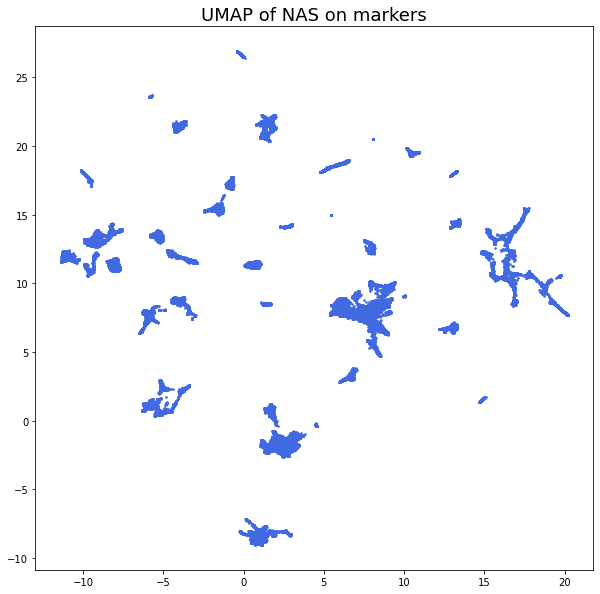

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [45]:
n_neighbors = 100
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if file_path.append_suffix('.npy').is_file():
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(file_path.append_suffix('.npy'))
    reducer = joblib.load(file_path.append_suffix('.pkl'))
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(file_path.append_suffix('.npy'), embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, file_path.append_suffix('.pkl'))

Computing dimensionality reduction


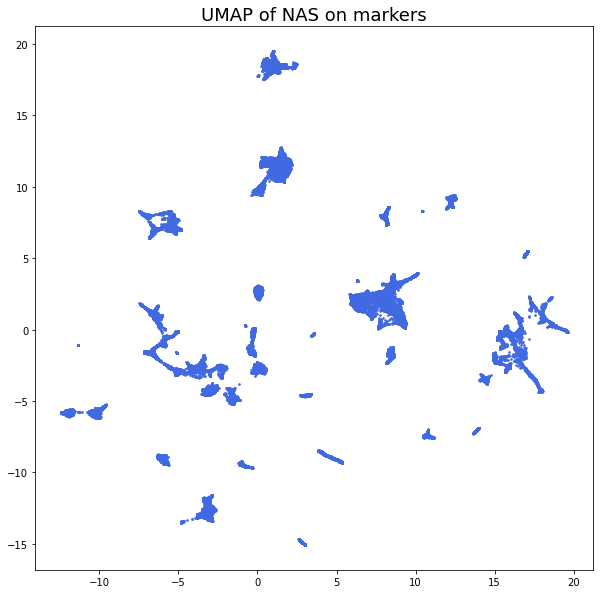

In [46]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

## Survival analysis

In [105]:
cell_types = nodes_all['CellCluster']
niches = cluster_labels

Text(0.5, 1.0, 'niche cell-types composition, normalized by cell-type')

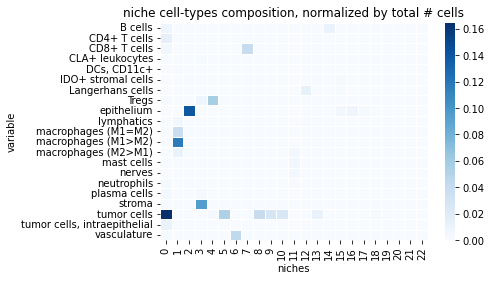

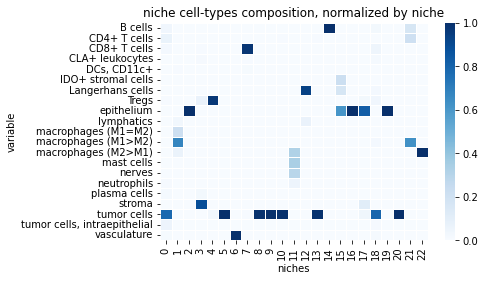

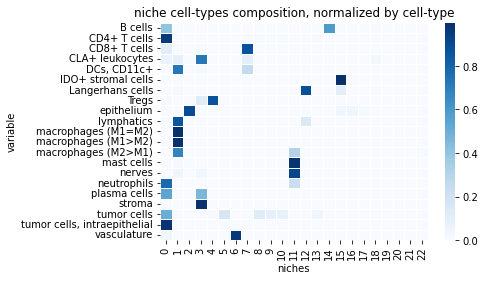

In [116]:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
plt.title("niche cell-types composition, normalized by total # cells")

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
plt.title("niche cell-types composition, normalized by cell-type")

In [117]:
# proportion of cells in niches per sample
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='obs')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.342813  0.245196  0.046887  0.257494  0.020753  0.000000   
reg002    0.280551  0.299914  0.009466  0.260327  0.089931  0.000000   
reg003    0.337118  0.179039  0.056769  0.141485  0.089956  0.000000   
reg004    0.226846  0.218792  0.009396  0.218792  0.075168  0.000000   
reg005    0.410714  0.125000  0.017857  0.428571  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
reg066    0.170455  0.328283  0.005051  0.151515  0.098485  0.000000   
reg067    0.132109  0.082346  0.055983  0.045320  0.013922  0.000000   
reg068    0.059776  0.126880  0.007713  0.082530  0.011955  0.000000   
reg069    0.289700  0.142704  0.152361  0.184549  0.018240  0.002146   
reg070    0.167715  0.314465  0.004193  0.343816  0.020964  0.000000   

niches          6         7         8         9   ...        13        14  \
variable                                          ...                       
reg001    0.000000  0.016141  0.001537  0.000000  ...  0.000000  0.016910   
reg002    0.001721  0.021515  0.003012  0.000000  ...  0.000000  0.004733   
reg003    0.059389  0.091703  0.000000  0.000000  ...  0.000000  0.002620   
reg004    0.100671  0.106040  0.000000  0.012081  ...  0.000000  0.000000   
reg005    0.008929  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...            ...       ...       ...       ...  ...       ...       ...   
reg066    0.050505  0.011364  0.000000  0.000000  ...  0.000000  0.000000   
reg067    0.024882  0.097453  0.000296  0.000000  ...  0.010367  0.008294   
reg068    0.019283  0.101427  0.000000  0.000000  ...  0.000000  0.005013   
reg069    0.064378  0.055794  0.000000  0.000000  ...  0.000000  0.000000   
reg070    0.113208  0.008386  0.000000  0.000000  ...  0.000000  0.000000   

niches          15   16        17        18        19   20        21   22  
variable                                                                   
reg001    0.016910  0.0  0.000000  0.001537  0.000000  0.0  0.000000  0.0  
reg002    0.008176  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg003    0.000000  0.0  0.001747  0.002620  0.000000  0.0  0.000000  0.0  
reg004    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg005    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
...            ...  ...       ...       ...       ...  ...       ...  ...  
reg066    0.126263  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg067    0.020438  0.0  0.008294  0.007998  0.000000  0.0  0.000000  0.0  
reg068    0.021597  0.0  0.001928  0.000386  0.000000  0.0  0.000771  0.0  
reg069    0.000000  0.0  0.033262  0.001073  0.001073  0.0  0.001073  0.0  
reg070    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  

[69 rows x 23 columns]

In [124]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [127]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       0.311682  0.272555  0.028177  0.258911  0.055342  0.000000   
         3       0.281982  0.198916  0.033082  0.180138  0.082562  0.000000   
2        1       0.321725  0.296849  0.006633  0.285240  0.000000  0.000000   
         3       0.015179  0.136672  0.045296  0.094102  0.015758  0.000000   
3        2       0.259294  0.137122  0.407933  0.103838  0.000722  0.000000   
         4       0.190874  0.112666  0.494947  0.066903  0.035041  0.000250   
4        2       0.328417  0.099656  0.303050  0.118416  0.000000  0.000000   
         4       0.201375  0.158157  0.184550  0.205320  0.057871  0.000243   
5        1       0.008651  0.025645  0.897337  0.040733  0.000000  0.000000   
         3       0.078367  0.165615  0.049015  0.475836  0.043475  0.000000   
6        2       0.296669  0.231134  0.002325  0.179545  0.038948  0.000000   
         4       0.270123  0.171922  0.172068  0.108982  0.105436  0.000211   
7        2       0.007782  0.085603  0.000000  0.381323  0.000000  0.000000   
         4       0.061317  0.135908  0.188097  0.376608  0.016244  0.000000   
8        2       0.391186  0.203368  0.065837  0.193564  0.006749  0.000000   
         4       0.100520  0.139589  0.017033  0.043897  0.011225  0.614975   
9        1       0.293393  0.115213  0.260883  0.200780  0.000000  0.000000   
         3       0.233951  0.120886  0.022325  0.156127  0.007917  0.000000   
10       1       0.072653  0.232653  0.256327  0.226939  0.000000  0.000000   
         3       0.063781  0.262718  0.293850  0.180714  0.003037  0.000000   
11       1       0.119898  0.143274  0.207181  0.308286  0.001357  0.000000   
         3       0.008830  0.077263  0.200883  0.359823  0.019868  0.000000   
12       2       0.238310  0.171853  0.272837  0.094578  0.057599  0.000000   
         4       0.184133  0.223163  0.041919  0.053049  0.038576  0.095904   
13       1       0.183952  0.091175  0.512245  0.111632  0.000462  0.000000   
         3       0.203820  0.150981  0.116547  0.135320  0.046123  0.000358   
14       2       0.295737  0.160874  0.123503  0.080341  0.204650  0.000000   
         4       0.207647  0.258868  0.018149  0.055130  0.130476  0.000000   

                       6         7         8         9   ...        13  \
Patients Groups                                          ...             
1        1       0.000861  0.018828  0.002275  0.000000  ...  0.000000   
         3       0.080030  0.098872  0.000000  0.006040  ...  0.000000   
2        1       0.028192  0.008292  0.001658  0.000000  ...  0.000000   
         3       0.037673  0.003942  0.000178  0.599181  ...  0.000000   
3        2       0.020719  0.022165  0.000254  0.000000  ...  0.000000   
         4       0.025759  0.033233  0.000952  0.000000  ...  0.000000   
4        2       0.061256  0.014058  0.007116  0.000000  ...  0.000000   
         4       0.087159  0.072699  0.000243  0.000000  ...  0.000000   
5        1       0.017890  0.000896  0.000000  0.000000  ...  0.000000   
         3       0.109622  0.005413  0.000000  0.008881  ...  0.000000   
6        2       0.053726  0.141242  0.000201  0.000000  ...  0.000000   
         4       0.047313  0.050475  0.020617  0.000000  ...  0.000000   
7        2       0.108949  0.000000  0.000000  0.000000  ...  0.000000   
         4       0.169487  0.009926  0.000000  0.000000  ...  0.000000   
8        2       0.067810  0.005664  0.001303  0.040398  ...  0.000000   
         4       0.011203  0.043212  0.000105  0.000000  ...  0.000105   
9        1       0.085591  0.016928  0.000487  0.000000  ...  0.000000   
         3       0.070376  0.057323  0.000074  0.000000  ...  0.034246   
10       1       0.105306  0.032653  0.003265  0.000000  ...  0.000000   
         3       0.140471  0.021260  0.009871  0.000000  ...  0.000000   
11       1       0.15355

/home/acoullom/Projects/mosna/mosna/mosna.py:1701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


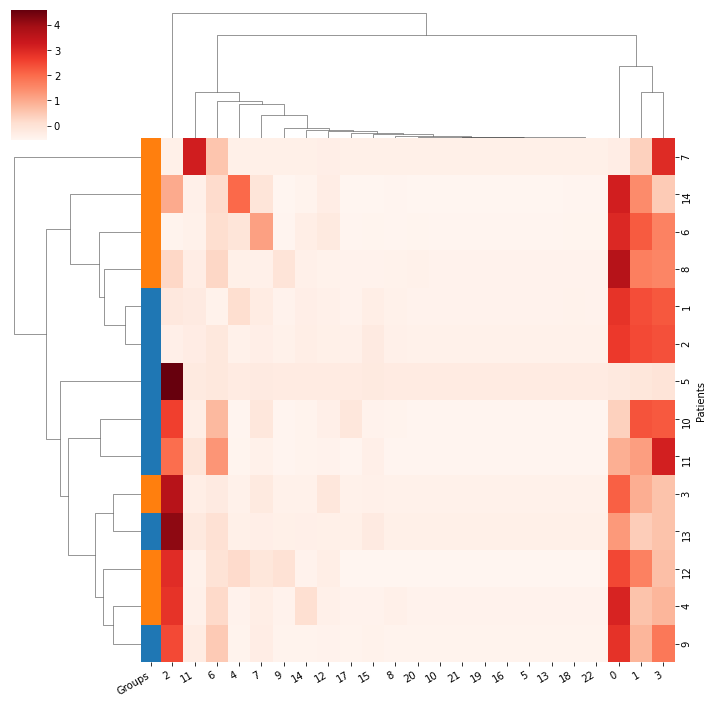

In [126]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

In [128]:
# proportion of cells in niches per sample, normalized per niche total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='niche')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.018037  0.015612  0.003745  0.026539  0.003884  0.000000   
reg002    0.026368  0.034111  0.001351  0.047928  0.030063  0.000000   
reg003    0.015610  0.010033  0.003990  0.012834  0.014816  0.000000   
reg004    0.006835  0.007977  0.000430  0.012913  0.008055  0.000000   
reg005    0.001860  0.000685  0.000123  0.003803  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
reg066    0.005460  0.012725  0.000246  0.009506  0.011220  0.000000   
reg067    0.018037  0.013605  0.011602  0.012121  0.006761  0.000000   
reg068    0.006268  0.016101  0.001228  0.016953  0.004459  0.000000   
reg069    0.010919  0.006509  0.008717  0.013626  0.002445  0.000322   
reg070    0.003235  0.007341  0.000123  0.012992  0.001438  0.000000   

niches          6         7         8         9   ...        13        14  \
variable                                          ...                       
reg001    0.000000  0.004402  0.000423  0.000000  ...  0.000000  0.016923   
reg002    0.000772  0.010480  0.001481  0.000000  ...  0.000000  0.008462   
reg003    0.013127  0.022008  0.000000  0.000000  ...  0.000000  0.002308   
reg004    0.014479  0.016558  0.000000  0.002826  ...  0.000000  0.000000   
reg005    0.000193  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...            ...       ...       ...       ...  ...       ...       ...   
reg066    0.007722  0.001886  0.000000  0.000000  ...  0.000000  0.000000   
reg067    0.016216  0.068958  0.000212  0.000000  ...  0.024356  0.021538   
reg068    0.009653  0.055125  0.000000  0.000000  ...  0.000000  0.010000   
reg069    0.011583  0.010899  0.000000  0.000000  ...  0.000000  0.000000   
reg070    0.010425  0.000838  0.000000  0.000000  ...  0.000000  0.000000   

niches          15   16        17        18        19   20        21   22  
variable                                                                   
reg001    0.020677  0.0  0.000000  0.005420  0.000000  0.0  0.000000  0.0  
reg002    0.017857  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg003    0.000000  0.0  0.005208  0.008130  0.000000  0.0  0.000000  0.0  
reg004    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg005    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
...            ...  ...       ...       ...       ...  ...       ...  ...  
reg066    0.093985  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg067    0.064850  0.0  0.072917  0.073171  0.000000  0.0  0.000000  0.0  
reg068    0.052632  0.0  0.013021  0.002710  0.000000  0.0  0.083333  0.0  
reg069    0.000000  0.0  0.080729  0.002710  0.016393  0.0  0.041667  0.0  
reg070    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  

[69 rows x 23 columns]

In [129]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [130]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       0.022202  0.024862  0.002548  0.037234  0.016974  0.000000   
         3       0.011223  0.009005  0.002210  0.012873  0.011436  0.000000   
2        1       0.007846  0.008760  0.000246  0.013626  0.000000  0.000000   
         3       0.001597  0.014462  0.007459  0.015765  0.005538  0.000000   
3        2       0.022607  0.014560  0.053990  0.017429  0.000216  0.000000   
         4       0.017309  0.012431  0.068600  0.011408  0.011148  0.000080   
4        2       0.020140  0.007292  0.027655  0.014458  0.000000  0.000000   
         4       0.014781  0.013263  0.020503  0.028004  0.014528  0.000080   
5        1       0.000182  0.000636  0.028023  0.001584  0.000000  0.000000   
         3       0.001719  0.004405  0.001688  0.020003  0.003452  0.000000   
6        2       0.028875  0.027211  0.000338  0.034302  0.013090  0.000000   
         4       0.027500  0.021044  0.025629  0.021726  0.038011  0.000080   
7        2       0.000081  0.001077  0.000000  0.007764  0.000000  0.000000   
         4       0.000849  0.001909  0.004236  0.008912  0.000719  0.000000   
8        2       0.027797  0.016150  0.006916  0.023185  0.001822  0.000000   
         4       0.012995  0.021909  0.003274  0.011117  0.005130  0.320030   
9        1       0.016096  0.005212  0.031952  0.014260  0.000000  0.000000   
         3       0.015186  0.011464  0.003668  0.019112  0.003057  0.000000   
10       1       0.003599  0.013948  0.019276  0.022023  0.000000  0.000000   
         3       0.003397  0.016933  0.023757  0.018854  0.000575  0.000000   
11       1       0.004186  0.005506  0.013996  0.014616  0.000216  0.000000   
         3       0.000162  0.001713  0.005586  0.012913  0.001295  0.000000   
12       2       0.011748  0.010571  0.026427  0.008160  0.011723  0.000000   
         4       0.010798  0.015318  0.002885  0.006496  0.008487  0.019472   
13       1       0.009989  0.006020  0.046071  0.011527  0.000072  0.000000   
         3       0.009484  0.008230  0.012001  0.008926  0.013353  0.000054   
14       2       0.017127  0.011868  0.013966  0.009229  0.044520  0.000000   
         4       0.026267  0.036724  0.003269  0.007774  0.056081  0.000000   

                       6         7         8         9   ...        13  \
Patients Groups                                          ...             
1        1       0.000386  0.007441  0.000952  0.000000  ...  0.000000   
         3       0.013803  0.019283  0.000000  0.001413  ...  0.000000   
2        1       0.003282  0.001048  0.000212  0.000000  ...  0.000000   
         3       0.016023  0.001991  0.000106  0.444898  ...  0.000000   
3        2       0.008301  0.010166  0.000106  0.000000  ...  0.000000   
         4       0.010714  0.015301  0.000423  0.000000  ...  0.000000   
4        2       0.018050  0.004506  0.002328  0.000000  ...  0.000000   
         4       0.029247  0.025781  0.000106  0.000000  ...  0.000000   
5        1       0.001737  0.000105  0.000000  0.000000  ...  0.000000   
         3       0.011390  0.000629  0.000000  0.001570  ...  0.000000   
6        2       0.024710  0.071264  0.000106  0.000000  ...  0.000000   
         4       0.022925  0.026776  0.011267  0.000000  ...  0.000000   
7        2       0.005405  0.000000  0.000000  0.000000  ...  0.000000   
         4       0.011873  0.000838  0.000000  0.000000  ...  0.000000   
8        2       0.020013  0.002166  0.000423  0.016013  ...  0.000000   
         4       0.006950  0.029204  0.000071  0.000000  ...  0.000232   
9        1       0.016216  0.003878  0.000212  0.000000  ...  0.000000   
         3       0.020319  0.032907  0.000053  0.000000  ...  0.031663   
10       1       0.024903  0.008384  0.000846  0.000000  ...  0.000000   
         3       0.035714  0.005869  0.002751  0.000000  ...  0.000000   
11       1       0.01380

/home/acoullom/Projects/mosna/mosna/mosna.py:1701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


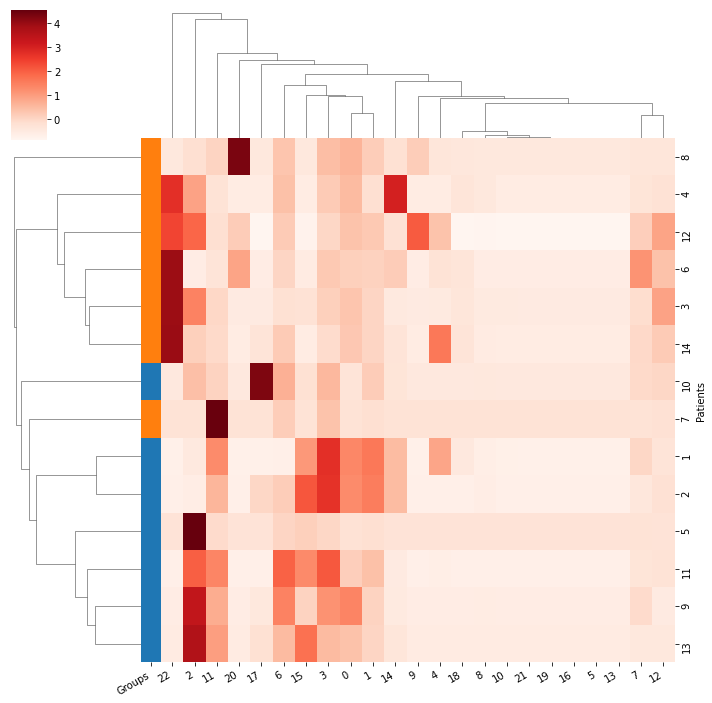

In [131]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

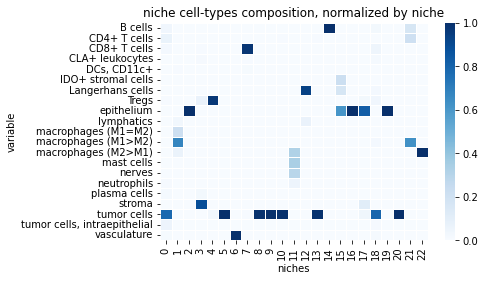

In [133]:
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
# plt.title("niche cell-types composition, normalized by total # cells")
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
# plt.title("niche cell-types composition, normalized by cell-type")

That look just great, but even if the idea that we should also somehow take into account proportions per niche fro normalization sounds correct, it doesn't seem right to ignore proportions per patient. For example if we normalize by the total number of cells we obtain again a very different result:

In [134]:
# proportion of cells in niches per sample, normalized per total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='total')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.003806  0.002723  0.000521  0.002859  0.000230  0.000000   
reg002    0.005565  0.005949  0.000188  0.005163  0.001784  0.000000   
reg003    0.003294  0.001750  0.000555  0.001383  0.000879  0.000000   
reg004    0.001442  0.001391  0.000060  0.001391  0.000478  0.000000   
reg005    0.000393  0.000119  0.000017  0.000410  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
reg066    0.001152  0.002219  0.000034  0.001024  0.000666  0.000000   
reg067    0.003806  0.002373  0.001613  0.001306  0.000401  0.000000   
reg068    0.001323  0.002808  0.000171  0.001826  0.000265  0.000000   
reg069    0.002304  0.001135  0.001212  0.001468  0.000145  0.000017   
reg070    0.000683  0.001280  0.000017  0.001400  0.000085  0.000000   

niches          6         7         8         9   ...        13        14  \
variable                                          ...                       
reg001    0.000000  0.000179  0.000017  0.000000  ...  0.000000  0.000188   
reg002    0.000034  0.000427  0.000060  0.000000  ...  0.000000  0.000094   
reg003    0.000580  0.000896  0.000000  0.000000  ...  0.000000  0.000026   
reg004    0.000640  0.000674  0.000000  0.000077  ...  0.000000  0.000000   
reg005    0.000009  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
...            ...       ...       ...       ...  ...       ...       ...   
reg066    0.000341  0.000077  0.000000  0.000000  ...  0.000000  0.000000   
reg067    0.000717  0.002808  0.000009  0.000000  ...  0.000299  0.000239   
reg068    0.000427  0.002245  0.000000  0.000000  ...  0.000000  0.000111   
reg069    0.000512  0.000444  0.000000  0.000000  ...  0.000000  0.000000   
reg070    0.000461  0.000034  0.000000  0.000000  ...  0.000000  0.000000   

niches          15   16        17        18        19   20        21   22  
variable                                                                   
reg001    0.000188  0.0  0.000000  0.000017  0.000000  0.0  0.000000  0.0  
reg002    0.000162  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg003    0.000000  0.0  0.000017  0.000026  0.000000  0.0  0.000000  0.0  
reg004    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg005    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
...            ...  ...       ...       ...       ...  ...       ...  ...  
reg066    0.000853  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  
reg067    0.000589  0.0  0.000239  0.000230  0.000000  0.0  0.000000  0.0  
reg068    0.000478  0.0  0.000043  0.000009  0.000000  0.0  0.000017  0.0  
reg069    0.000000  0.0  0.000265  0.000009  0.000009  0.0  0.000009  0.0  
reg070    0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000  0.0  

[69 rows x 23 columns]

In [135]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [136]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       0.004685  0.004336  0.000354  0.004011  0.001007  0.000000   
         3       0.002368  0.001570  0.000307  0.001387  0.000679  0.000000   
2        1       0.001656  0.001528  0.000034  0.001468  0.000000  0.000000   
         3       0.000337  0.002522  0.001037  0.001698  0.000329  0.000000   
3        2       0.004771  0.002539  0.007506  0.001878  0.000013  0.000000   
         4       0.003653  0.002168  0.009537  0.001229  0.000661  0.000004   
4        2       0.004250  0.001272  0.003845  0.001558  0.000000  0.000000   
         4       0.003119  0.002313  0.002851  0.003017  0.000862  0.000004   
5        1       0.000038  0.000111  0.003896  0.000171  0.000000  0.000000   
         3       0.000363  0.000768  0.000235  0.002155  0.000205  0.000000   
6        2       0.006094  0.004745  0.000047  0.003695  0.000777  0.000000   
         4       0.005804  0.003670  0.003563  0.002341  0.002255  0.000004   
7        2       0.000017  0.000188  0.000000  0.000836  0.000000  0.000000   
         4       0.000179  0.000333  0.000589  0.000960  0.000043  0.000000   
8        2       0.005866  0.002816  0.000962  0.002498  0.000108  0.000000   
         4       0.002742  0.003821  0.000455  0.001198  0.000304  0.016972   
9        1       0.003397  0.000909  0.004442  0.001536  0.000000  0.000000   
         3       0.003205  0.001999  0.000510  0.002059  0.000181  0.000000   
10       1       0.000760  0.002432  0.002680  0.002373  0.000000  0.000000   
         3       0.000717  0.002953  0.003303  0.002031  0.000034  0.000000   
11       1       0.000883  0.000960  0.001946  0.001575  0.000013  0.000000   
         3       0.000034  0.000299  0.000777  0.001391  0.000077  0.000000   
12       2       0.002479  0.001843  0.003674  0.000879  0.000696  0.000000   
         4       0.002279  0.002671  0.000401  0.000700  0.000504  0.001033   
13       1       0.002108  0.001050  0.006405  0.001242  0.000004  0.000000   
         3       0.002001  0.001435  0.001669  0.000962  0.000792  0.000003   
14       2       0.003614  0.002070  0.001942  0.000994  0.002641  0.000000   
         4       0.005543  0.006404  0.000454  0.000837  0.003327  0.000000   

                       6         7         8         9   ...        13  \
Patients Groups                                          ...             
1        1       0.000017  0.000303  0.000038  0.000000  ...  0.000000   
         3       0.000610  0.000785  0.000000  0.000038  ...  0.000000   
2        1       0.000145  0.000043  0.000009  0.000000  ...  0.000000   
         3       0.000708  0.000081  0.000004  0.012094  ...  0.000000   
3        2       0.000367  0.000414  0.000004  0.000000  ...  0.000000   
         4       0.000474  0.000623  0.000017  0.000000  ...  0.000000   
4        2       0.000798  0.000183  0.000094  0.000000  ...  0.000000   
         4       0.001293  0.001050  0.000004  0.000000  ...  0.000000   
5        1       0.000077  0.000004  0.000000  0.000000  ...  0.000000   
         3       0.000504  0.000026  0.000000  0.000043  ...  0.000000   
6        2       0.001092  0.002902  0.000004  0.000000  ...  0.000000   
         4       0.001013  0.001090  0.000454  0.000000  ...  0.000000   
7        2       0.000239  0.000000  0.000000  0.000000  ...  0.000000   
         4       0.000525  0.000034  0.000000  0.000000  ...  0.000000   
8        2       0.000885  0.000088  0.000017  0.000435  ...  0.000000   
         4       0.000307  0.001189  0.000003  0.000000  ...  0.000003   
9        1       0.000717  0.000158  0.000009  0.000000  ...  0.000000   
         3       0.000898  0.001340  0.000002  0.000000  ...  0.000388   
10       1       0.001101  0.000341  0.000034  0.000000  ...  0.000000   
         3       0.001579  0.000239  0.000111  0.000000  ...  0.000000   
11       1       0.00061

/home/acoullom/Projects/mosna/mosna/mosna.py:1701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


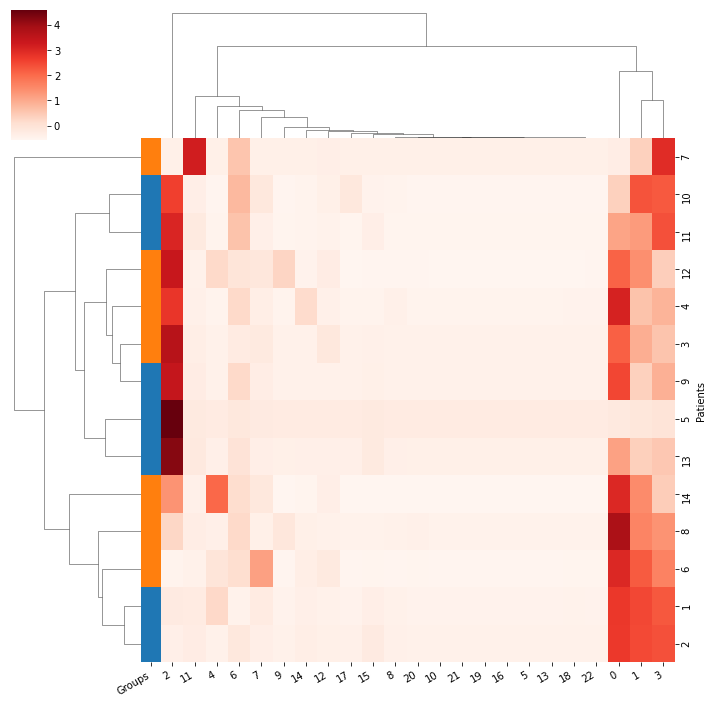

In [137]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

A more statistically sound way to take jointly into account proportions per variable and per observation is the Central Log Ratio, that we already applied to protein composition:

In [144]:
# proportion of cells in niches per sample, normalized with Central Log Ratio
reload(mosna)
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='clr')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    6.055561  5.720433  4.066116  5.769372  3.251079 -3.726464   
reg002    6.098199  6.164940  2.709197  6.023383  4.960489 -4.063550   
reg003    5.861741  5.228913  4.080290  4.993500  4.540632 -3.775802   
reg004    5.608473  5.572325  2.424485  5.572325  4.503926 -3.203131   
reg005    6.070248  4.880664  2.934753  6.112807 -1.440099 -1.440099   
...            ...       ...       ...       ...       ...       ...   
reg066    5.344638  6.000045  1.825657  5.226855  4.796072 -3.242342   
reg067    4.390488  3.917790  3.531916  3.320607  2.140316 -5.391537   
reg068    4.040958  4.793591  1.993265  4.363509  2.431520 -4.684172   
reg069    5.216144  4.508071  4.573549  4.765216  2.450935  0.310869   
reg070    5.494605  6.123213  1.805725  6.212444  3.415163 -2.569127   

niches          6         7         8         9   ...        13        14  \
variable                                          ...                       
reg001   -3.726464  2.999764  0.648389 -3.726464  ... -3.726464  3.046284   
reg002    1.004449  3.530178  1.564065 -4.063550  ... -4.063550  2.016050   
reg003    4.125411  4.559864 -3.775802 -3.775802  ... -3.775802  1.004515   
reg004    4.796063  4.848022 -3.203131  2.675799  ... -3.203131 -3.203131   
reg005    2.241606 -1.440099 -1.440099 -1.440099  ... -1.440099 -1.440099   
...            ...       ...       ...       ...  ...       ...       ...   
reg066    4.128242  2.636587 -3.242342 -3.242342  ... -3.242342 -3.242342   
reg067    2.720985  4.086226 -1.709831 -5.391537  ...  1.845517  1.622373   
reg068    2.909556  4.569687 -4.684172 -4.684172  ... -4.684172  1.562483   
reg069    3.712066  3.568965 -4.063984 -4.063984  ... -4.063984 -4.063984   
reg070    5.101562  2.498872 -2.569127 -2.569127  ... -2.569127 -2.569127   

niches          15        16        17        18        19        20  \
variable                                                               
reg001    3.046284 -3.726464 -3.726464  0.648389 -3.726464 -3.726464   
reg002    2.562594 -4.063550 -4.063550 -4.063550 -4.063550 -4.063550   
reg003   -3.775802 -3.775802  0.599050  1.004515 -3.775802 -3.775802   
reg004   -3.203131 -3.203131 -3.203131 -3.203131 -3.203131 -3.203131   
reg005   -1.440099 -1.440099 -1.440099 -1.440099 -1.440099 -1.440099   
...            ...       ...       ...       ...       ...       ...   
reg066    5.044533 -3.242342 -3.242342 -3.242342 -3.242342 -3.242342   
reg067    2.524275 -5.391537  1.622373  1.586006 -5.391537 -5.391537   
reg068    3.022885 -4.684172  0.606971 -1.002467 -4.684172 -4.684172   
reg069   -4.063984 -4.063984  3.051709 -0.382278 -0.382278 -4.063984   
reg070   -2.569127 -2.569127 -2.569127 -2.569127 -2.569127 -2.569127   

niches          21        22  
variable                      
reg001   -3.726464 -3.726464  
reg002   -4.063550 -4.063550  
reg003   -3.775802 -3.775802  
reg004   -3.203131 -3.203131  
reg005   -1.440099 -1.440099  
...            ...       ...  
reg066   -3.242342 -3.242342  
reg067   -5.391537 -5.391537  
reg068   -0.309320 -4.684172  
reg069   -0.382278 -4.063984  
reg070   -2.569127 -2.569127  

[69 rows x 23 columns]

In [145]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [146]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       6.076880  5.942687  3.387656  5.896378  4.105784 -3.895007   
         3       5.735107  5.400619  3.252388  5.282912  4.522279 -3.489466   
2        1       5.767622  5.687150  1.886058  5.647258 -3.181941 -3.181941   
         3       2.377709  4.711618  3.277512  4.293609  2.582097 -4.648796   
3        2       6.090174  5.448602  6.543296  5.158228  0.116199 -3.912080   
         4       5.653200  5.125040  6.604361  4.531358  3.949726 -2.241218   
4        2       6.155321  4.958678  6.067067  5.130653 -3.724241 -3.724241   
         4       5.742550  5.511036  5.658679  5.775500  4.514889 -1.931384   
5        1       3.192680  4.309476  7.864678  4.710957 -1.934211 -1.934211   
         3       4.198953  4.938863  2.801580  5.960690  3.439946 -3.211845   
6        2       5.950824  5.701612  0.971233  5.444510  3.263717 -4.299499   
         4       5.934630  5.462224  5.338046  4.862576  4.993872 -3.149686   
7        2       2.702895  5.100790 -1.671958  6.594715 -1.671958 -1.671958   
         4       4.168980  4.839760  5.148245  5.940506  2.835366 -2.455777   
8        2       6.229336  5.627172  4.499118  5.535377  1.799199 -3.815538   
         4       4.326102  5.544188  3.104283  4.371280  2.961204  7.019061   
9        1       6.374875  5.241583  5.324934  5.761519 -3.106932 -3.106932   
         3       5.196721  4.774760  2.586371  4.814890  1.808164 -4.315801   
10       1       4.332566  5.496419  5.593322  5.471551 -3.837776 -3.837776   
         3       4.210270  5.625892  5.737878  5.251724  1.165748 -3.902252   
11       1       5.094048  5.322964  3.851961  6.004943 -0.499734 -2.889893   
         3       1.780889  3.949943  4.905455  5.488345  2.591820 -3.287110   
12       2       5.410665  5.099793  5.496579  4.382190  4.019926 -3.928509   
         4       4.815681  5.011467  2.800715  3.507947  3.206180  4.067563   
13       1       5.857513  5.158841  6.869341  5.327538 -1.490880 -3.331733   
         3       4.507386  4.225761  3.420915  3.650846  2.892829 -3.746474   
14       2       5.711853  5.129353  3.522643  4.419632  5.370040 -4.018405   
         4       5.538358  6.143826  0.796827  3.949968  5.348645 -4.024919   

                       6         7         8         9   ...        13  \
Patients Groups                                          ...             
1        1      -1.361007  3.264971  1.106227 -3.895007  ... -3.895007   
         3       4.460737  4.703943 -3.489466 -0.550001  ... -3.489466   
2        1       3.332977  2.109202  0.499764 -3.181941  ... -3.181941   
         3       3.450588  1.211264 -2.807943  6.247253  ... -4.648796   
3        2       3.465949  3.610866 -2.071227 -3.912080  ... -3.912080   
         4       3.580669  3.886705  0.148941 -4.082070  ... -4.082070   
4        2       4.475458  3.003119  2.316714 -3.724241  ... -3.724241   
         4       4.923338  4.720827 -1.931384 -3.772236  ... -3.772236   
5        1       3.944719 -0.093359 -1.934211 -1.934211  ... -1.934211   
         3       4.546823  1.274579 -3.211845 -0.219700  ... -3.211845   
6        2       4.204014  5.208441 -2.458647 -4.299499  ... -4.299499   
         4       4.064080  4.241833 -0.107524 -4.243399  ... -4.243399   
7        2       5.341952 -1.671958 -1.671958 -1.671958  ... -1.671958   
         4       5.079010  0.424796 -2.455777 -2.455777  ... -2.455777   
8        2       4.484163  1.776201  0.463421  1.472756  ... -3.815538   
         4       2.992758  4.241342 -3.012087 -4.239322  ... -3.012087   
9        1       5.003816  3.462050 -0.919505 -3.106932  ... -3.106932   
         3       3.928558  3.598127 -3.395375 -4.315801  ... -0.338504   
10       1       4.703742  3.532809  1.230224 -3.837776  ... -3.837776   
         3       4.999809  3.111658  2.344403 -3.902252  ... -3.902252   
11       1       4.93758

/home/acoullom/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


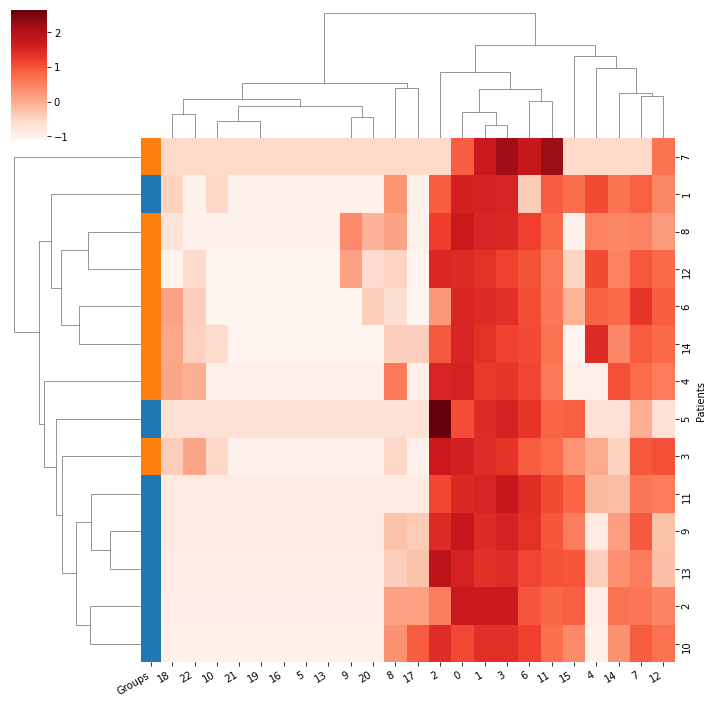

In [147]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

With this more statistically sound way of normalizing data we still obtain a good, although not perfect, blind clustering of patients into responders and non responders.

In [148]:
# the colorbar is just wrong
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
s = d.style.background_gradient(cmap=cm)
s

In [149]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [150]:
pvals.head(20)

pval  pval_corr
15  0.000583   0.013403
22  0.053030   0.304924
18  0.053030   0.304924
12  0.053030   0.304924
19  0.212121   0.443526
4   0.212121   0.443526
5   0.212121   0.443526
17  0.212121   0.443526
16  0.212121   0.443526
13  0.212121   0.443526
21  0.212121   0.443526
20  0.575175   0.696264
14  0.575175   0.696264
11  0.575175   0.696264
9   0.575175   0.696264
7   0.575175   0.696264
3   0.575175   0.696264
1   0.575175   0.696264
10  0.575175   0.696264
8   0.962704   0.962704

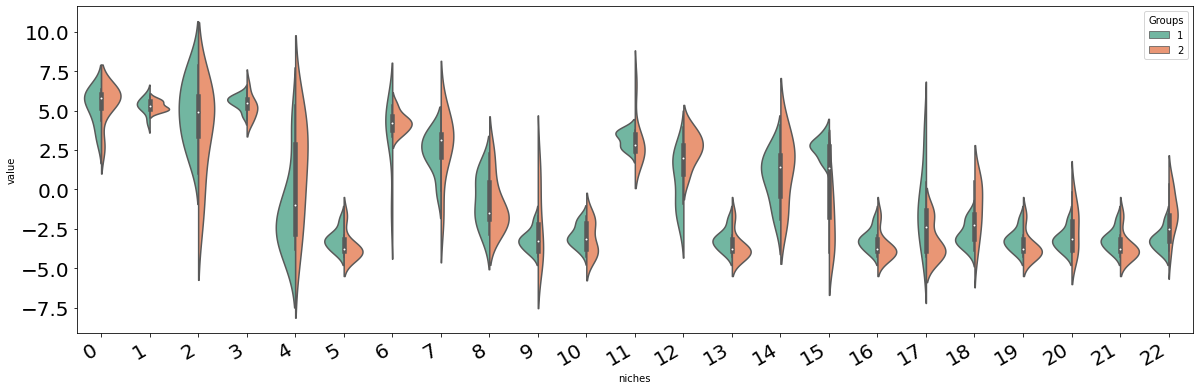

In [151]:
# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

From this plot we would like to add niches 4 and 17 to those that seggregate patients into groups 1 and 2.

Add                              15 with p-value 6.70293e-05
Add                              22 with p-value 0.0165379


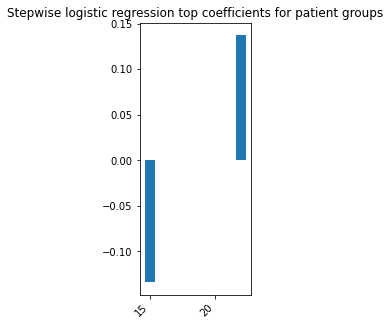

In [154]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(coefs.index, coefs)
        plt.xticks(rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")

##### Elasticnet logistic regression

In [155]:
def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10

In [156]:
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

In [158]:
nas_dir

PosixPath('../data/processed/CODEX_CTCL/all_samples_networks_xy_trim_dist-200_solitary-0/nas_on-markers_stats-mean-std_order-1')







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

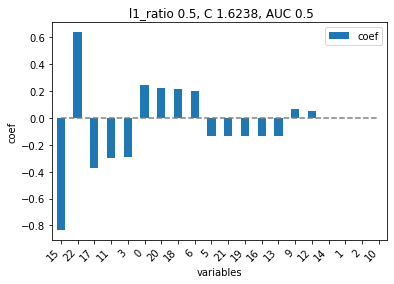

<Figure size 432x288 with 0 Axes>

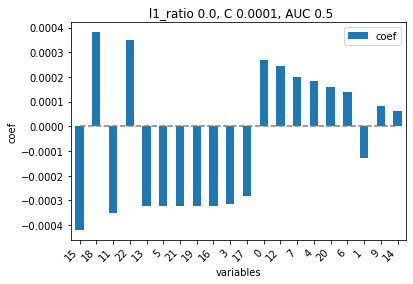

<Figure size 432x288 with 0 Axes>

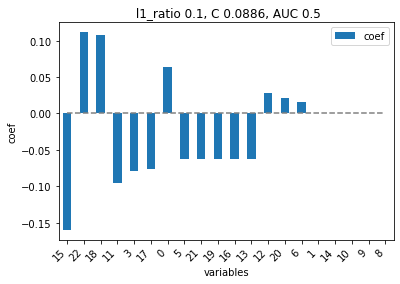

In [163]:
start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

It is quite surprising that the ROC og log reg models are 0.5, whereas we do have statistically different distributions for some variables. To investigate...

In [ ]:
save_dir = cluster_dir / (clusterer_name + "_spatial_networks_figures")
save_dir.mkdir(parents=True, exist_ok=True)

sample_ids = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = np.array([labels_color_mapper[x] for x in cluster_labels])

# colormap for cell-types
n_cell_types = obj['ClusterName'].unique().size
# palette = sns.color_palette(cc.glasbey, n_colors=n_cell_types).as_hex()
palette = [mpl.colors.rgb2hex(x) for x in mpl.cm.get_cmap('tab20').colors]

plots_marker = '.'
for sample in sample_ids:
    print("filename: {}".format(sample))
    select = np.array(obj['FileName'] == sample)

    # load nodes and edges
    coords = obj.loc[select, cell_pos_cols].values
    pairs = edges_all.loc[edges_all['filename'] == sample, ['source', 'target']].values

    # Big summary plot
    fig, ax = plt.subplots(1, 4, figsize=(int(7*4)+1, 7), tight_layout=False)
    i = 0
    ty.plot_network(coords, pairs, labels=obj.loc[select, 'ClusterName'], cmap_nodes=palette, marker=plots_marker, size_nodes=size_points, ax=ax[0])
    ax[i].set_title('Spatial map of phenotypes', fontsize=14);

    i += 1
    ax[i].scatter(coords[:, 0], coords[:, 1], c=cluster_colors[select], marker=plots_marker, s=size_points)
    ax[i].set_title('Spatial map of detected areas', fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[select, 0], embed_viz[select, 1], c=cluster_colors[select], s=5);
    ax[i].set_title("HDBSCAN clustering on NAS", fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors);
    ax[i].set_title("HDBSCAN clustering on NAS of all samples", fontsize=14);
    ax[i].set_aspect('equal')
    
    # make plot limits equal
    ax[i-1].set_xlim(ax[i].get_xlim())
    ax[i-1].set_ylim(ax[i].get_ylim())

    suptitle = f"Spatial omics data and detected areas - sample {sample}";
    fig.suptitle(suptitle, fontsize=18)

    fig.savefig(save_dir / suptitle, bbox_inches='tight', facecolor='white', dpi=300)